In this project, your goal is to write a software pipeline to identify the lane boundaries in video from a front-facing camera on a car. The camera calibration images, test road images, and videos are available in this repository. Your job is to take what you've learned in this lesson and write a great lane-finding pipeline! Check out the project rubric for details on what's expected in your submission.

In [ ]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.signal import find_peaks_cwt
%matplotlib inline

In [ ]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
pattern_size = (nx, ny)
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
h, w = 0, 0

images = glob.glob('camera_cal/*.jpg')
for fname in images:
    print('processing %s... ' % fname, end='\t')
    img = cv2.imread(fname)
    if img is None:
        print("Failed to load", fname)
        continue
        
    h, w = img.shape[:2]
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size)

    # If found, add object points, image points (after refining them)
    if ret:
        cv2.cornerSubPix(gray, corners,(5, 5),(-1, -1), criteria)
    else:
        print('chessboard not found')
        continue
    imgpoints.append(corners.reshape(-1, 2))
    objpoints.append(pattern_points)
    print('ok')
    
# Calculate camera matrix and distortion
ret, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w ,h), None, None)
print("\nRMS:", ret)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients:\n", dist_coefs.ravel())

new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
print("new camera matrix:\n", new_camera_matrix)
    
#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(300)
#     cv2.destroyAllWindows()

processing camera_cal/calibration11.jpg... 	ok
processing camera_cal/calibration2.jpg... 	ok
processing camera_cal/calibration14.jpg... 	ok
processing camera_cal/calibration5.jpg... 	chessboard not found
processing camera_cal/calibration7.jpg... 	ok
processing camera_cal/calibration19.jpg... 	ok
processing camera_cal/calibration8.jpg... 	ok
processing camera_cal/calibration1.jpg... 	chessboard not found
processing camera_cal/calibration17.jpg... 	ok
processing camera_cal/calibration18.jpg... 	ok
processing camera_cal/calibration15.jpg... 	ok
processing camera_cal/calibration16.jpg... 	ok
processing camera_cal/calibration20.jpg... 	ok
processing camera_cal/calibration9.jpg... 	ok
processing camera_cal/calibration10.jpg... 	ok
processing camera_cal/calibration6.jpg... 	ok
processing camera_cal/calibration3.jpg... 	ok
processing camera_cal/calibration12.jpg... 	ok
processing camera_cal/calibration13.jpg... 	ok
processing camera_cal/calibration4.jpg... 	

In [ ]:
img = cv2.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, new_camera_matrix)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
def draw_lines(img, left_line, right_line, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    if left_line.any():
        vx, vy, cx, cy = left_line
        w1 = (cy - img.shape[0]) / vy
        w2 = -(cy - img.shape[0] * 0.6) / vy
        cv2.line(img, (int(cx-vx*w1), img.shape[0]), (int(cx+vx*w2), int(img.shape[0] * 0.6)), color, thickness)
        
    if right_line.any():
        vx, vy, cx, cy = right_line
        w1 = (cy - img.shape[0]) / vy
        w2 = -(cy - img.shape[0] * 0.6) / vy
        cv2.line(img, (int(cx-vx*w1), img.shape[0]), (int(cx+vx*w2), int(img.shape[0] * 0.6)), color, thickness)
            
def solve_lines(lines):
    left_points = np.array([]).reshape((0,2))
    right_points = np.array([]).reshape((0,2))
    left_line = np.array([])
    right_line = np.array([])
    for line in lines:
        for x1,y1,x2,y2 in line:
            deg = math.atan2((y2-y1), (x2-x1)) / np.pi * 180 
            #print(deg)
            
            #print(x1, y1)
            #print(x2, y2)
            
            #if (deg >= -40 and deg <= -30):    
            if (x1 < 640 and x2 < 640):
                left_points = np.vstack([left_points, (x1, y1), (x2, y2)])
            #elif ((deg >= 30 and deg <= 40)):
            elif (x1 > 640 and x2 > 640):
                right_points = np.vstack([right_points, (x1, y1), (x2, y2)])
    
    if (left_points.any()):
        left_line = cv2.fitLine(left_points, cv2.DIST_L2, 0, 0.01, 0.01)  
    if (right_points.any()):
        right_line = cv2.fitLine(right_points, cv2.DIST_L2, 0, 0.01, 0.01)  
    
    return left_line, right_line
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #use least squares to fit lines to singe left and right one
    left_line, right_line = solve_lines(lines)
    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, left_line, right_line, [255, 0, 0], 8)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    #undistorted = cv2.undistort(image, camera_matrix, dist_coefs, None, new_camera_matrix)
    undistorted = cv2.undistort(image, camera_matrix, dist_coefs, None, camera_matrix)
    
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    #thresh_H = (45, 75)
    thresh_H = (15, 100)
    thresh_S = (90, 255)
    thresh_abssx = (30, 150)
    
    # Threshold color channel
    h_binary = cv2.inRange(H, thresh_H[0], thresh_H[1])
    retval, s_binary = cv2.threshold(S.astype('uint8'), thresh_S[0], thresh_S[1], cv2.THRESH_BINARY)
    
    # Combine the two binary thresholds
    combined_color_binary = np.zeros_like(h_binary)
    combined_color_binary[(h_binary == 255) & (s_binary == 255)] = 255
    
    # Grayscale image
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold x gradient
    sxbinary = cv2.inRange(abssx, thresh_abssx[0], thresh_abssx[1])   
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(combined_color_binary == 255) | (sxbinary == 255)] = 255
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = combined_binary.shape
    vertices = np.array([[(imshape[1] * 0.15, imshape[0]), (imshape[1] * 0.4, imshape[0] * 0.6),
                        (imshape[1] * 0.6, imshape[0] * 0.6), (imshape[1], imshape[0])]],
                        dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(combined_binary)   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(combined_binary, mask)
    
    #kernel = np.ones((3,3),np.uint8)
    #opening = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, kernel)
    
    # Grab the image shape
    img_size = (masked_image.shape[1], masked_image.shape[0])
    
#     src = np.float32([[imshape[1] * 0.15, imshape[0]], 
#                       [imshape[1] * 0.4, imshape[0] * 0.6], 
#                       [imshape[1] * 0.6, imshape[0] * 0.6], 
#                       [imshape[1], imshape[0]]])
    
    src = np.float32([[0, 700], 
                      [560, 460], 
                      [720, 460], 
                      [1280, 700]])
        
    dst = np.float32([[img_size[0] / 4, img_size[1]],
                      [img_size[0] / 4, 0], 
                      [img_size[0] * 3 / 4, 0], 
                      [img_size[0] * 3 / 4, img_size[1]]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(masked_image, M, img_size)

    # The lane lines should appear parallel in the warped images
    # With this histogram I am adding up the pixel values along each column in the image
    
    #normalize to 0 & 1
    warped = warped / 255
    
    # height x width = 720 x 1280
    sliding_window_num = 6
    sliding_window_height = warped.shape[0] // sliding_window_num
    # search +- 50 pixels
    sliding_window_width = 50 
    
    sliding_window_mask = np.zeros_like(warped) 
    
    for i in range(0, sliding_window_num):
        top = i * sliding_window_height
        bottom = (i + 1) * sliding_window_height
        band = warped[top:bottom, :]
        histogram = np.sum(band, axis = 0)
        plt.plot(histogram)
        #peak = find_peaks_cwt(histogram, np.arange(1, warped.shape[1]))
        peak = find_peaks_cwt(histogram, [100], max_distances = [100])
        peak_value = [histogram[index] for index in peak]
        peak_sorted = np.argsort(peak_value) 
        # reverse order
        peak_sorted = peak_sorted[::-1]

        #print(peak)
        #print(peak_value)
        
        if ((peak_sorted.shape[0] > 0) and 
            (peak[peak_sorted[0]] >= warped.shape[1] / 4) and
            (peak[peak_sorted[0]] <= warped.shape[1] * 3 /4)):
            sliding_window_mask[top:bottom, (peak[peak_sorted[0]] - sliding_window_width) : (peak[peak_sorted[0]] + sliding_window_width)] = 1
        if (peak_sorted.shape[0] > 1 and 
            peak[peak_sorted[1]] >= warped.shape[1] / 4 and
            peak[peak_sorted[1]] <= warped.shape[1] * 3 /4):
            sliding_window_mask[top:bottom, (peak[peak_sorted[1]] - sliding_window_width) : (peak[peak_sorted[1]] + sliding_window_width)] = 1
        
    warped_mask = cv2.bitwise_and(warped, sliding_window_mask)
    warped_mask = np.uint8(warped_mask)
    
#     # Define the Hough transform parameters
#     # Make a blank the same size as our image to draw on
#     rho = 2 # distance resolution in pixels of the Hough grid
#     theta = np.pi/180 # angular resolution in radians of the Hough grid
#     threshold = 15     # minimum number of votes (intersections in Hough grid cell)
#     min_line_length = 70 #minimum number of pixels making up a line
#     max_line_gap = 100    # maximum gap in pixels between connectable line segments
#     line_image = np.zeros_like(warped_mask)  # creating a blank to draw lines on
    
#     # Run Hough on edge detected image
#     # Output "lines" is an array containing endpoints of detected line segments
    
#     line_image = hough_lines(warped_mask, rho, theta, threshold, min_line_length, max_line_gap)
    
    
#     # Generate some fake data to represent lane-line pixels
#     yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
#     leftx = np.array([200 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
#                                   for idx, elem in enumerate(yvals)])
#     leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#     rightx = np.array([900 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
#                                     for idx, elem in enumerate(yvals)])
#     rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

#     # Fit a second order polynomial to each fake lane line
#     left_fit = np.polyfit(yvals, leftx, 2)
#     left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
#     right_fit = np.polyfit(yvals, rightx, 2)
#     right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

    #pixel_points = np.transpose(np.nonzero(warped_mask))
    pixel_points = cv2.findNonZero(warped_mask)
    #print(pixel_points)
    pixel_points = np.reshape(pixel_points, (-1, 2))
    #print(pixel_points)

#     pixel_points = np.float32(pixel_points)
    
#     # define criteria and apply kmeans()
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#     ret,label,center=cv2.kmeans(pixel_points,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    
    blank_image_classified = np.zeros_like(undistorted) 
    
#     for point, allocation in zip(pixel_points, label):
#         if allocation == 0:
#             color = (255,0,0)
#         elif allocation == 1:
#             color = (0,0,255)
#         cv2.circle(blank_image_classified, (int(point[0]),int(point[1])), 1, color,-1)

    leftx = np.array([])
    lefty = np.array([])
    rightx = np.array([])
    righty = np.array([])
    
    for point in pixel_points:
        #print(point)
        if (point[0] < warped_mask.shape[1] / 2 and point[0] >= warped_mask.shape[1] / 4):
            color = (255,0,0)
            cv2.circle(blank_image_classified, (int(point[0]),int(point[1])), 1, color,-1)
            leftx = np.append(leftx, point[0])
            lefty = np.append(lefty, point[1])
        elif(point[0] >= warped_mask.shape[1] / 2 and point[0] <= warped_mask.shape[1] * 3 / 4):
            color = (0,0,255)
            cv2.circle(blank_image_classified, (int(point[0]),int(point[1])), 1, color,-1)
            rightx = np.append(rightx, point[0])
            righty = np.append(righty, point[1])
            
    #print(leftx)
    #cv2.imshow("Points", blank_image)
    cv2.imshow("Points Classified", blank_image_classified)
    
    #print(leftx)
    
    #Fit a second order polynomial to each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    line_image = np.zeros_like(undistorted)  # creating a blank to draw lines on
    
    
    yvals = yvals.reshape(-1, 1)
    left_fitx = left_fitx.reshape(-1, 1)
    right_fitx = right_fitx.reshape(-1, 1)
    #print(yvals)
    pts_left = np.hstack(([left_fitx,yvals]))
    pts_right = np.hstack(([right_fitx,yvals]))
    pts_right = pts_right[::-1]
    pts = np.vstack((pts_left, pts_right))

    #print (pts)
    
    #pts = np.float32(pts)
    
    #print(pts.shape)
    
    cv2.polylines(line_image,np.int_([pts_left]), False,(0, 0, 255), 4)
    cv2.polylines(line_image,np.int_([pts_right]), False,(255, 0, 0), 4)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(line_image, np.int_([pts]), (0, 255, 0))
    
    
    warped_inv = cv2.warpPerspective(line_image, Minv, img_size)
    result = cv2.addWeighted(undistorted, 1, warped_inv, 1, 0)
    
    
    cv2.imshow('input', image)
    #cv2.imshow('output_H', h_binary)
    #cv2.imshow('output_S', s_binary)
    #cv2.imshow('output_combine_color', combined_color_binary)
    #cv2.imshow('output_grad', sxbinary)
    cv2.imshow('output_combine', combined_binary)
    #cv2.imshow('mask', mask)
    cv2.imshow('output_mask', masked_image)
    cv2.imshow('warped', warped)
    cv2.imshow('slide', sliding_window_mask)
    warped_mask = warped_mask * 255
    cv2.imshow('warped_mask', warped_mask)
    cv2.imshow('line', line_image)
    cv2.imshow('result', result)
    
    cv2.waitKey(100)
    
    #image = line_image
    #image = np.dstack(( line_image, line_image, line_image))
    #result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    
    return result
    #return undistorted

[[  548.31854957     0.        ]
 [  545.57214316     7.2       ]
 [  542.86309912    14.4       ]
 [  540.19141748    21.6       ]
 [  537.55709823    28.8       ]
 [  534.96014136    36.        ]
 [  532.40054688    43.2       ]
 [  529.87831479    50.4       ]
 [  527.39344509    57.6       ]
 [  524.94593777    64.8       ]
 [  522.53579284    72.        ]
 [  520.1630103     79.2       ]
 [  517.82759015    86.4       ]
 [  515.52953239    93.6       ]
 [  513.26883702   100.8       ]
 [  511.04550403   108.        ]
 [  508.85953343   115.2       ]
 [  506.71092522   122.4       ]
 [  504.5996794    129.6       ]
 [  502.52579596   136.8       ]
 [  500.48927491   144.        ]
 [  498.49011625   151.2       ]
 [  496.52831998   158.4       ]
 [  494.6038861    165.6       ]
 [  492.71681461   172.8       ]
 [  490.8671055    180.        ]
 [  489.05475878   187.2       ]
 [  487.27977445   194.4       ]
 [  485.54215251   201.6       ]
 [  483.84189295   208.8       ]
 [  482.17

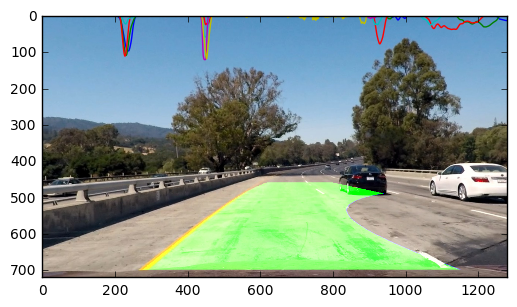

In [221]:
img = mpimg.imread('test_images/test1.jpg')
out = process_image(img)
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.imshow(out)

[[ 364.79412784    0.        ]
 [ 366.6792683     7.2       ]
 [ 368.54828126   14.4       ]
 [ 370.40116673   21.6       ]
 [ 372.2379247    28.8       ]
 [ 374.05855518   36.        ]
 [ 375.86305816   43.2       ]
 [ 377.65143365   50.4       ]
 [ 379.42368165   57.6       ]
 [ 381.17980215   64.8       ]
 [ 382.91979516   72.        ]
 [ 384.64366068   79.2       ]
 [ 386.3513987    86.4       ]
 [ 388.04300922   93.6       ]
 [ 389.71849225  100.8       ]
 [ 391.37784779  108.        ]
 [ 393.02107583  115.2       ]
 [ 394.64817638  122.4       ]
 [ 396.25914944  129.6       ]
 [ 397.853995    136.8       ]
 [ 399.43271306  144.        ]
 [ 400.99530364  151.2       ]
 [ 402.54176671  158.4       ]
 [ 404.0721023   165.6       ]
 [ 405.58631039  172.8       ]
 [ 407.08439098  180.        ]
 [ 408.56634408  187.2       ]
 [ 410.03216969  194.4       ]
 [ 411.4818678   201.6       ]
 [ 412.91543842  208.8       ]
 [ 414.33288155  216.        ]
 [ 415.73419718  223.2       ]
 [ 417.1









  0%|          | 0/1261 [00:00<?, ?it/s]







  0%|          | 1/1261 [00:01<23:18,  1.11s/it]

[[ 364.79412784    0.        ]
 [ 366.6792683     7.2       ]
 [ 368.54828126   14.4       ]
 [ 370.40116673   21.6       ]
 [ 372.2379247    28.8       ]
 [ 374.05855518   36.        ]
 [ 375.86305816   43.2       ]
 [ 377.65143365   50.4       ]
 [ 379.42368165   57.6       ]
 [ 381.17980215   64.8       ]
 [ 382.91979516   72.        ]
 [ 384.64366068   79.2       ]
 [ 386.3513987    86.4       ]
 [ 388.04300922   93.6       ]
 [ 389.71849225  100.8       ]
 [ 391.37784779  108.        ]
 [ 393.02107583  115.2       ]
 [ 394.64817638  122.4       ]
 [ 396.25914944  129.6       ]
 [ 397.853995    136.8       ]
 [ 399.43271306  144.        ]
 [ 400.99530364  151.2       ]
 [ 402.54176671  158.4       ]
 [ 404.0721023   165.6       ]
 [ 405.58631039  172.8       ]
 [ 407.08439098  180.        ]
 [ 408.56634408  187.2       ]
 [ 410.03216969  194.4       ]
 [ 411.4818678   201.6       ]
 [ 412.91543842  208.8       ]
 [ 414.33288155  216.        ]
 [ 415.73419718  223.2       ]
 [ 417.1









  0%|          | 2/1261 [00:02<23:25,  1.12s/it]

[[ 365.27148372    0.        ]
 [ 367.15258839    7.2       ]
 [ 369.01772178   14.4       ]
 [ 370.8668839    21.6       ]
 [ 372.70007475   28.8       ]
 [ 374.51729432   36.        ]
 [ 376.31854263   43.2       ]
 [ 378.10381965   50.4       ]
 [ 379.87312541   57.6       ]
 [ 381.62645989   64.8       ]
 [ 383.36382309   72.        ]
 [ 385.08521503   79.2       ]
 [ 386.79063569   86.4       ]
 [ 388.48008508   93.6       ]
 [ 390.15356319  100.8       ]
 [ 391.81107003  108.        ]
 [ 393.4526056   115.2       ]
 [ 395.07816989  122.4       ]
 [ 396.68776291  129.6       ]
 [ 398.28138466  136.8       ]
 [ 399.85903514  144.        ]
 [ 401.42071434  151.2       ]
 [ 402.96642227  158.4       ]
 [ 404.49615892  165.6       ]
 [ 406.0099243   172.8       ]
 [ 407.50771841  180.        ]
 [ 408.98954125  187.2       ]
 [ 410.45539281  194.4       ]
 [ 411.9052731   201.6       ]
 [ 413.33918211  208.8       ]
 [ 414.75711985  216.        ]
 [ 416.15908632  223.2       ]
 [ 417.5









  0%|          | 3/1261 [00:03<22:29,  1.07s/it]

[[ 364.4028166     0.        ]
 [ 366.33284681    7.2       ]
 [ 368.24615198   14.4       ]
 [ 370.1427321    21.6       ]
 [ 372.02258718   28.8       ]
 [ 373.88571721   36.        ]
 [ 375.7321222    43.2       ]
 [ 377.56180214   50.4       ]
 [ 379.37475703   57.6       ]
 [ 381.17098688   64.8       ]
 [ 382.95049169   72.        ]
 [ 384.71327144   79.2       ]
 [ 386.45932616   86.4       ]
 [ 388.18865582   93.6       ]
 [ 389.90126045  100.8       ]
 [ 391.59714002  108.        ]
 [ 393.27629455  115.2       ]
 [ 394.93872404  122.4       ]
 [ 396.58442848  129.6       ]
 [ 398.21340787  136.8       ]
 [ 399.82566222  144.        ]
 [ 401.42119153  151.2       ]
 [ 402.99999578  158.4       ]
 [ 404.562075    165.6       ]
 [ 406.10742916  172.8       ]
 [ 407.63605829  180.        ]
 [ 409.14796236  187.2       ]
 [ 410.64314139  194.4       ]
 [ 412.12159538  201.6       ]
 [ 413.58332432  208.8       ]
 [ 415.02832821  216.        ]
 [ 416.45660706  223.2       ]
 [ 417.8









  0%|          | 4/1261 [00:04<21:26,  1.02s/it]

[[ 366.09130731    0.        ]
 [ 367.97010289    7.2       ]
 [ 369.83314547   14.4       ]
 [ 371.68043507   21.6       ]
 [ 373.51197168   28.8       ]
 [ 375.3277553    36.        ]
 [ 377.12778593   43.2       ]
 [ 378.91206357   50.4       ]
 [ 380.68058822   57.6       ]
 [ 382.43335989   64.8       ]
 [ 384.17037856   72.        ]
 [ 385.89164425   79.2       ]
 [ 387.59715695   86.4       ]
 [ 389.28691666   93.6       ]
 [ 390.96092339  100.8       ]
 [ 392.61917712  108.        ]
 [ 394.26167787  115.2       ]
 [ 395.88842562  122.4       ]
 [ 397.49942039  129.6       ]
 [ 399.09466217  136.8       ]
 [ 400.67415097  144.        ]
 [ 402.23788677  151.2       ]
 [ 403.78586958  158.4       ]
 [ 405.31809941  165.6       ]
 [ 406.83457625  172.8       ]
 [ 408.3353001   180.        ]
 [ 409.82027096  187.2       ]
 [ 411.28948883  194.4       ]
 [ 412.74295371  201.6       ]
 [ 414.18066561  208.8       ]
 [ 415.60262452  216.        ]
 [ 417.00883044  223.2       ]
 [ 418.3









  0%|          | 5/1261 [00:05<21:07,  1.01s/it]

[[ 364.0032643     0.        ]
 [ 365.92323781    7.2       ]
 [ 367.82718933   14.4       ]
 [ 369.71511886   21.6       ]
 [ 371.58702639   28.8       ]
 [ 373.44291194   36.        ]
 [ 375.28277549   43.2       ]
 [ 377.10661704   50.4       ]
 [ 378.91443661   57.6       ]
 [ 380.70623418   64.8       ]
 [ 382.48200977   72.        ]
 [ 384.24176336   79.2       ]
 [ 385.98549495   86.4       ]
 [ 387.71320456   93.6       ]
 [ 389.42489217  100.8       ]
 [ 391.12055779  108.        ]
 [ 392.80020142  115.2       ]
 [ 394.46382306  122.4       ]
 [ 396.1114227   129.6       ]
 [ 397.74300035  136.8       ]
 [ 399.35855601  144.        ]
 [ 400.95808968  151.2       ]
 [ 402.54160136  158.4       ]
 [ 404.10909104  165.6       ]
 [ 405.66055873  172.8       ]
 [ 407.19600443  180.        ]
 [ 408.71542814  187.2       ]
 [ 410.21882985  194.4       ]
 [ 411.70620957  201.6       ]
 [ 413.1775673   208.8       ]
 [ 414.63290304  216.        ]
 [ 416.07221679  223.2       ]
 [ 417.4









  0%|          | 6/1261 [00:06<21:30,  1.03s/it]

[[ 359.52084722    0.        ]
 [ 361.57509175    7.2       ]
 [ 363.61160763   14.4       ]
 [ 365.63039487   21.6       ]
 [ 367.63145345   28.8       ]
 [ 369.61478339   36.        ]
 [ 371.58038468   43.2       ]
 [ 373.52825732   50.4       ]
 [ 375.45840131   57.6       ]
 [ 377.37081666   64.8       ]
 [ 379.26550335   72.        ]
 [ 381.1424614    79.2       ]
 [ 383.0016908    86.4       ]
 [ 384.84319155   93.6       ]
 [ 386.66696365  100.8       ]
 [ 388.4730071   108.        ]
 [ 390.26132191  115.2       ]
 [ 392.03190807  122.4       ]
 [ 393.78476558  129.6       ]
 [ 395.51989444  136.8       ]
 [ 397.23729465  144.        ]
 [ 398.93696621  151.2       ]
 [ 400.61890913  158.4       ]
 [ 402.28312339  165.6       ]
 [ 403.92960901  172.8       ]
 [ 405.55836598  180.        ]
 [ 407.1693943   187.2       ]
 [ 408.76269397  194.4       ]
 [ 410.338265    201.6       ]
 [ 411.89610737  208.8       ]
 [ 413.4362211   216.        ]
 [ 414.95860618  223.2       ]
 [ 416.4









  1%|          | 7/1261 [00:07<22:24,  1.07s/it]

[[ 357.87617716    0.        ]
 [ 359.91145128    7.2       ]
 [ 361.92989923   14.4       ]
 [ 363.93152102   21.6       ]
 [ 365.91631664   28.8       ]
 [ 367.88428609   36.        ]
 [ 369.83542938   43.2       ]
 [ 371.7697465    50.4       ]
 [ 373.68723746   57.6       ]
 [ 375.58790224   64.8       ]
 [ 377.47174087   72.        ]
 [ 379.33875332   79.2       ]
 [ 381.18893961   86.4       ]
 [ 383.02229974   93.6       ]
 [ 384.83883369  100.8       ]
 [ 386.63854148  108.        ]
 [ 388.42142311  115.2       ]
 [ 390.18747857  122.4       ]
 [ 391.93670786  129.6       ]
 [ 393.66911098  136.8       ]
 [ 395.38468794  144.        ]
 [ 397.08343874  151.2       ]
 [ 398.76536336  158.4       ]
 [ 400.43046182  165.6       ]
 [ 402.07873412  172.8       ]
 [ 403.71018025  180.        ]
 [ 405.32480021  187.2       ]
 [ 406.922594    194.4       ]
 [ 408.50356163  201.6       ]
 [ 410.0677031   208.8       ]
 [ 411.61501839  216.        ]
 [ 413.14550752  223.2       ]
 [ 414.6









  1%|          | 8/1261 [00:08<22:38,  1.08s/it]

[[ 357.60162277    0.        ]
 [ 359.64917471    7.2       ]
 [ 361.68000926   14.4       ]
 [ 363.69412641   21.6       ]
 [ 365.69152616   28.8       ]
 [ 367.67220852   36.        ]
 [ 369.63617349   43.2       ]
 [ 371.58342105   50.4       ]
 [ 373.51395122   57.6       ]
 [ 375.427764     64.8       ]
 [ 377.32485938   72.        ]
 [ 379.20523737   79.2       ]
 [ 381.06889796   86.4       ]
 [ 382.91584115   93.6       ]
 [ 384.74606695  100.8       ]
 [ 386.55957535  108.        ]
 [ 388.35636635  115.2       ]
 [ 390.13643996  122.4       ]
 [ 391.89979618  129.6       ]
 [ 393.646435    136.8       ]
 [ 395.37635642  144.        ]
 [ 397.08956045  151.2       ]
 [ 398.78604708  158.4       ]
 [ 400.46581632  165.6       ]
 [ 402.12886816  172.8       ]
 [ 403.7752026   180.        ]
 [ 405.40481965  187.2       ]
 [ 407.0177193   194.4       ]
 [ 408.61390156  201.6       ]
 [ 410.19336642  208.8       ]
 [ 411.75611389  216.        ]
 [ 413.30214396  223.2       ]
 [ 414.8









  1%|          | 9/1261 [00:09<22:33,  1.08s/it]

[[ 356.41067207    0.        ]
 [ 358.41869914    7.2       ]
 [ 360.41104294   14.4       ]
 [ 362.38770345   21.6       ]
 [ 364.3486807    28.8       ]
 [ 366.29397466   36.        ]
 [ 368.22358535   43.2       ]
 [ 370.13751277   50.4       ]
 [ 372.03575691   57.6       ]
 [ 373.91831777   64.8       ]
 [ 375.78519536   72.        ]
 [ 377.63638967   79.2       ]
 [ 379.4719007    86.4       ]
 [ 381.29172846   93.6       ]
 [ 383.09587294  100.8       ]
 [ 384.88433415  108.        ]
 [ 386.65711208  115.2       ]
 [ 388.41420674  122.4       ]
 [ 390.15561812  129.6       ]
 [ 391.88134622  136.8       ]
 [ 393.59139105  144.        ]
 [ 395.2857526   151.2       ]
 [ 396.96443087  158.4       ]
 [ 398.62742587  165.6       ]
 [ 400.27473759  172.8       ]
 [ 401.90636604  180.        ]
 [ 403.52231121  187.2       ]
 [ 405.12257311  194.4       ]
 [ 406.70715172  201.6       ]
 [ 408.27604707  208.8       ]
 [ 409.82925913  216.        ]
 [ 411.36678792  223.2       ]
 [ 412.8









  1%|          | 10/1261 [00:10<22:47,  1.09s/it]

[[ 353.40513977    0.        ]
 [ 355.43519243    7.2       ]
 [ 357.44971481   14.4       ]
 [ 359.4487069    21.6       ]
 [ 361.43216871   28.8       ]
 [ 363.40010024   36.        ]
 [ 365.35250148   43.2       ]
 [ 367.28937244   50.4       ]
 [ 369.21071311   57.6       ]
 [ 371.1165235    64.8       ]
 [ 373.0068036    72.        ]
 [ 374.88155342   79.2       ]
 [ 376.74077296   86.4       ]
 [ 378.58446221   93.6       ]
 [ 380.41262118  100.8       ]
 [ 382.22524986  108.        ]
 [ 384.02234826  115.2       ]
 [ 385.80391638  122.4       ]
 [ 387.56995421  129.6       ]
 [ 389.32046176  136.8       ]
 [ 391.05543902  144.        ]
 [ 392.774886    151.2       ]
 [ 394.47880269  158.4       ]
 [ 396.1671891   165.6       ]
 [ 397.84004523  172.8       ]
 [ 399.49737107  180.        ]
 [ 401.13916663  187.2       ]
 [ 402.7654319   194.4       ]
 [ 404.37616689  201.6       ]
 [ 405.97137159  208.8       ]
 [ 407.55104601  216.        ]
 [ 409.11519015  223.2       ]
 [ 410.6









  1%|          | 11/1261 [00:11<22:20,  1.07s/it]

[[ 352.9221201     0.        ]
 [ 354.92226546    7.2       ]
 [ 356.90771669   14.4       ]
 [ 358.87847378   21.6       ]
 [ 360.83453674   28.8       ]
 [ 362.77590557   36.        ]
 [ 364.70258026   43.2       ]
 [ 366.61456083   50.4       ]
 [ 368.51184726   57.6       ]
 [ 370.39443955   64.8       ]
 [ 372.26233772   72.        ]
 [ 374.11554175   79.2       ]
 [ 375.95405165   86.4       ]
 [ 377.77786741   93.6       ]
 [ 379.58698904  100.8       ]
 [ 381.38141654  108.        ]
 [ 383.16114991  115.2       ]
 [ 384.92618914  122.4       ]
 [ 386.67653424  129.6       ]
 [ 388.41218521  136.8       ]
 [ 390.13314205  144.        ]
 [ 391.83940475  151.2       ]
 [ 393.53097332  158.4       ]
 [ 395.20784775  165.6       ]
 [ 396.87002806  172.8       ]
 [ 398.51751423  180.        ]
 [ 400.15030627  187.2       ]
 [ 401.76840417  194.4       ]
 [ 403.37180794  201.6       ]
 [ 404.96051758  208.8       ]
 [ 406.53453309  216.        ]
 [ 408.09385446  223.2       ]
 [ 409.6









  1%|          | 12/1261 [00:12<22:20,  1.07s/it]

[[ 347.57998422    0.        ]
 [ 349.5681733     7.2       ]
 [ 351.54273396   14.4       ]
 [ 353.50366621   21.6       ]
 [ 355.45097005   28.8       ]
 [ 357.38464547   36.        ]
 [ 359.30469248   43.2       ]
 [ 361.21111107   50.4       ]
 [ 363.10390125   57.6       ]
 [ 364.98306302   64.8       ]
 [ 366.84859637   72.        ]
 [ 368.70050131   79.2       ]
 [ 370.53877784   86.4       ]
 [ 372.36342595   93.6       ]
 [ 374.17444565  100.8       ]
 [ 375.97183694  108.        ]
 [ 377.75559981  115.2       ]
 [ 379.52573427  122.4       ]
 [ 381.28224031  129.6       ]
 [ 383.02511794  136.8       ]
 [ 384.75436716  144.        ]
 [ 386.46998796  151.2       ]
 [ 388.17198035  158.4       ]
 [ 389.86034433  165.6       ]
 [ 391.53507989  172.8       ]
 [ 393.19618704  180.        ]
 [ 394.84366577  187.2       ]
 [ 396.47751609  194.4       ]
 [ 398.097738    201.6       ]
 [ 399.70433149  208.8       ]
 [ 401.29729657  216.        ]
 [ 402.87663324  223.2       ]
 [ 404.4









  1%|          | 13/1261 [00:13<22:22,  1.08s/it]

[[ 348.30188574    0.        ]
 [ 350.24161144    7.2       ]
 [ 352.16880577   14.4       ]
 [ 354.08346873   21.6       ]
 [ 355.98560032   28.8       ]
 [ 357.87520054   36.        ]
 [ 359.75226938   43.2       ]
 [ 361.61680686   50.4       ]
 [ 363.46881296   57.6       ]
 [ 365.3082877    64.8       ]
 [ 367.13523106   72.        ]
 [ 368.94964305   79.2       ]
 [ 370.75152367   86.4       ]
 [ 372.54087292   93.6       ]
 [ 374.3176908   100.8       ]
 [ 376.08197731  108.        ]
 [ 377.83373244  115.2       ]
 [ 379.57295621  122.4       ]
 [ 381.2996486   129.6       ]
 [ 383.01380963  136.8       ]
 [ 384.71543928  144.        ]
 [ 386.40453756  151.2       ]
 [ 388.08110447  158.4       ]
 [ 389.74514001  165.6       ]
 [ 391.39664417  172.8       ]
 [ 393.03561697  180.        ]
 [ 394.66205839  187.2       ]
 [ 396.27596845  194.4       ]
 [ 397.87734713  201.6       ]
 [ 399.46619444  208.8       ]
 [ 401.04251039  216.        ]
 [ 402.60629496  223.2       ]
 [ 404.1









  1%|          | 14/1261 [00:14<22:02,  1.06s/it]

[[ 347.96992943    0.        ]
 [ 349.88658034    7.2       ]
 [ 351.79125418   14.4       ]
 [ 353.68395097   21.6       ]
 [ 355.5646707    28.8       ]
 [ 357.43341337   36.        ]
 [ 359.29017899   43.2       ]
 [ 361.13496754   50.4       ]
 [ 362.96777904   57.6       ]
 [ 364.78861348   64.8       ]
 [ 366.59747086   72.        ]
 [ 368.39435118   79.2       ]
 [ 370.17925444   86.4       ]
 [ 371.95218064   93.6       ]
 [ 373.71312979  100.8       ]
 [ 375.46210188  108.        ]
 [ 377.19909691  115.2       ]
 [ 378.92411488  122.4       ]
 [ 380.63715579  129.6       ]
 [ 382.33821965  136.8       ]
 [ 384.02730644  144.        ]
 [ 385.70441618  151.2       ]
 [ 387.36954886  158.4       ]
 [ 389.02270448  165.6       ]
 [ 390.66388304  172.8       ]
 [ 392.29308455  180.        ]
 [ 393.91030899  187.2       ]
 [ 395.51555638  194.4       ]
 [ 397.10882671  201.6       ]
 [ 398.69011998  208.8       ]
 [ 400.25943619  216.        ]
 [ 401.81677534  223.2       ]
 [ 403.3









  1%|          | 15/1261 [00:15<21:35,  1.04s/it]

[[ 351.26143005    0.        ]
 [ 353.12076261    7.2       ]
 [ 354.96862634   14.4       ]
 [ 356.80502122   21.6       ]
 [ 358.62994726   28.8       ]
 [ 360.44340446   36.        ]
 [ 362.24539282   43.2       ]
 [ 364.03591234   50.4       ]
 [ 365.81496302   57.6       ]
 [ 367.58254485   64.8       ]
 [ 369.33865784   72.        ]
 [ 371.08330199   79.2       ]
 [ 372.8164773    86.4       ]
 [ 374.53818377   93.6       ]
 [ 376.24842139  100.8       ]
 [ 377.94719018  108.        ]
 [ 379.63449012  115.2       ]
 [ 381.31032122  122.4       ]
 [ 382.97468348  129.6       ]
 [ 384.6275769   136.8       ]
 [ 386.26900147  144.        ]
 [ 387.89895721  151.2       ]
 [ 389.5174441   158.4       ]
 [ 391.12446215  165.6       ]
 [ 392.72001136  172.8       ]
 [ 394.30409173  180.        ]
 [ 395.87670325  187.2       ]
 [ 397.43784594  194.4       ]
 [ 398.98751978  201.6       ]
 [ 400.52572478  208.8       ]
 [ 402.05246094  216.        ]
 [ 403.56772826  223.2       ]
 [ 405.0









  1%|▏         | 16/1261 [00:16<21:20,  1.03s/it]

[[ 351.1234256     0.        ]
 [ 353.04095961    7.2       ]
 [ 354.94573146   14.4       ]
 [ 356.83774112   21.6       ]
 [ 358.71698862   28.8       ]
 [ 360.58347395   36.        ]
 [ 362.4371971    43.2       ]
 [ 364.27815808   50.4       ]
 [ 366.10635688   57.6       ]
 [ 367.92179352   64.8       ]
 [ 369.72446798   72.        ]
 [ 371.51438027   79.2       ]
 [ 373.29153038   86.4       ]
 [ 375.05591833   93.6       ]
 [ 376.8075441   100.8       ]
 [ 378.5464077   108.        ]
 [ 380.27250913  115.2       ]
 [ 381.98584838  122.4       ]
 [ 383.68642546  129.6       ]
 [ 385.37424037  136.8       ]
 [ 387.04929311  144.        ]
 [ 388.71158367  151.2       ]
 [ 390.36111207  158.4       ]
 [ 391.99787829  165.6       ]
 [ 393.62188233  172.8       ]
 [ 395.23312421  180.        ]
 [ 396.83160391  187.2       ]
 [ 398.41732144  194.4       ]
 [ 399.9902768   201.6       ]
 [ 401.55046998  208.8       ]
 [ 403.097901    216.        ]
 [ 404.63256984  223.2       ]
 [ 406.1









  1%|▏         | 17/1261 [00:17<21:01,  1.01s/it]

[[ 352.41777149    0.        ]
 [ 354.25159062    7.2       ]
 [ 356.07419538   14.4       ]
 [ 357.88558576   21.6       ]
 [ 359.68576178   28.8       ]
 [ 361.47472343   36.        ]
 [ 363.25247071   43.2       ]
 [ 365.01900362   50.4       ]
 [ 366.77432216   57.6       ]
 [ 368.51842634   64.8       ]
 [ 370.25131614   72.        ]
 [ 371.97299158   79.2       ]
 [ 373.68345264   86.4       ]
 [ 375.38269934   93.6       ]
 [ 377.07073167  100.8       ]
 [ 378.74754963  108.        ]
 [ 380.41315322  115.2       ]
 [ 382.06754244  122.4       ]
 [ 383.7107173   129.6       ]
 [ 385.34267778  136.8       ]
 [ 386.9634239   144.        ]
 [ 388.57295564  151.2       ]
 [ 390.17127302  158.4       ]
 [ 391.75837603  165.6       ]
 [ 393.33426467  172.8       ]
 [ 394.89893894  180.        ]
 [ 396.45239884  187.2       ]
 [ 397.99464437  194.4       ]
 [ 399.52567554  201.6       ]
 [ 401.04549233  208.8       ]
 [ 402.55409476  216.        ]
 [ 404.05148281  223.2       ]
 [ 405.5









  1%|▏         | 18/1261 [00:18<21:09,  1.02s/it]

[[ 352.68792198    0.        ]
 [ 354.49417643    7.2       ]
 [ 356.28966376   14.4       ]
 [ 358.07438397   21.6       ]
 [ 359.84833707   28.8       ]
 [ 361.61152304   36.        ]
 [ 363.36394189   43.2       ]
 [ 365.10559362   50.4       ]
 [ 366.83647824   57.6       ]
 [ 368.55659573   64.8       ]
 [ 370.2659461    72.        ]
 [ 371.96452935   79.2       ]
 [ 373.65234548   86.4       ]
 [ 375.32939449   93.6       ]
 [ 376.99567638  100.8       ]
 [ 378.65119115  108.        ]
 [ 380.2959388   115.2       ]
 [ 381.92991933  122.4       ]
 [ 383.55313274  129.6       ]
 [ 385.16557903  136.8       ]
 [ 386.7672582   144.        ]
 [ 388.35817025  151.2       ]
 [ 389.93831518  158.4       ]
 [ 391.50769299  165.6       ]
 [ 393.06630367  172.8       ]
 [ 394.61414724  180.        ]
 [ 396.15122369  187.2       ]
 [ 397.67753302  194.4       ]
 [ 399.19307523  201.6       ]
 [ 400.69785031  208.8       ]
 [ 402.19185828  216.        ]
 [ 403.67509913  223.2       ]
 [ 405.1









  2%|▏         | 19/1261 [00:19<20:58,  1.01s/it]

[[ 350.31473706    0.        ]
 [ 352.13036242    7.2       ]
 [ 353.93531045   14.4       ]
 [ 355.72958115   21.6       ]
 [ 357.51317453   28.8       ]
 [ 359.28609058   36.        ]
 [ 361.0483293    43.2       ]
 [ 362.79989069   50.4       ]
 [ 364.54077475   57.6       ]
 [ 366.27098149   64.8       ]
 [ 367.9905109    72.        ]
 [ 369.69936298   79.2       ]
 [ 371.39753773   86.4       ]
 [ 373.08503516   93.6       ]
 [ 374.76185526  100.8       ]
 [ 376.42799803  108.        ]
 [ 378.08346347  115.2       ]
 [ 379.72825158  122.4       ]
 [ 381.36236237  129.6       ]
 [ 382.98579583  136.8       ]
 [ 384.59855196  144.        ]
 [ 386.20063076  151.2       ]
 [ 387.79203224  158.4       ]
 [ 389.37275638  165.6       ]
 [ 390.9428032   172.8       ]
 [ 392.50217269  180.        ]
 [ 394.05086486  187.2       ]
 [ 395.58887969  194.4       ]
 [ 397.1162172   201.6       ]
 [ 398.63287738  208.8       ]
 [ 400.13886023  216.        ]
 [ 401.63416576  223.2       ]
 [ 403.1









  2%|▏         | 20/1261 [00:20<20:54,  1.01s/it]

[[ 349.05853436    0.        ]
 [ 350.85839418    7.2       ]
 [ 352.64795466   14.4       ]
 [ 354.42721582   21.6       ]
 [ 356.19617764   28.8       ]
 [ 357.95484012   36.        ]
 [ 359.70320328   43.2       ]
 [ 361.4412671    50.4       ]
 [ 363.16903158   57.6       ]
 [ 364.88649673   64.8       ]
 [ 366.59366255   72.        ]
 [ 368.29052904   79.2       ]
 [ 369.97709619   86.4       ]
 [ 371.65336401   93.6       ]
 [ 373.31933249  100.8       ]
 [ 374.97500164  108.        ]
 [ 376.62037146  115.2       ]
 [ 378.25544194  122.4       ]
 [ 379.88021309  129.6       ]
 [ 381.49468491  136.8       ]
 [ 383.09885739  144.        ]
 [ 384.69273054  151.2       ]
 [ 386.27630435  158.4       ]
 [ 387.84957883  165.6       ]
 [ 389.41255398  172.8       ]
 [ 390.9652298   180.        ]
 [ 392.50760628  187.2       ]
 [ 394.03968342  194.4       ]
 [ 395.56146124  201.6       ]
 [ 397.07293972  208.8       ]
 [ 398.57411887  216.        ]
 [ 400.06499868  223.2       ]
 [ 401.5









  2%|▏         | 21/1261 [00:21<20:37,  1.00it/s]

[[ 347.38878683    0.        ]
 [ 349.16550777    7.2       ]
 [ 350.93256668   14.4       ]
 [ 352.68996357   21.6       ]
 [ 354.43769845   28.8       ]
 [ 356.1757713    36.        ]
 [ 357.90418213   43.2       ]
 [ 359.62293095   50.4       ]
 [ 361.33201774   57.6       ]
 [ 363.03144251   64.8       ]
 [ 364.72120526   72.        ]
 [ 366.40130599   79.2       ]
 [ 368.0717447    86.4       ]
 [ 369.73252139   93.6       ]
 [ 371.38363606  100.8       ]
 [ 373.02508871  108.        ]
 [ 374.65687934  115.2       ]
 [ 376.27900795  122.4       ]
 [ 377.89147454  129.6       ]
 [ 379.4942791   136.8       ]
 [ 381.08742165  144.        ]
 [ 382.67090218  151.2       ]
 [ 384.24472068  158.4       ]
 [ 385.80887717  165.6       ]
 [ 387.36337164  172.8       ]
 [ 388.90820408  180.        ]
 [ 390.44337451  187.2       ]
 [ 391.96888291  194.4       ]
 [ 393.48472929  201.6       ]
 [ 394.99091366  208.8       ]
 [ 396.487436    216.        ]
 [ 397.97429632  223.2       ]
 [ 399.4









  2%|▏         | 22/1261 [00:22<21:07,  1.02s/it]

[[ 345.10341793    0.        ]
 [ 346.867752      7.2       ]
 [ 348.62281067   14.4       ]
 [ 350.36859393   21.6       ]
 [ 352.10510179   28.8       ]
 [ 353.83233425   36.        ]
 [ 355.5502913    43.2       ]
 [ 357.25897295   50.4       ]
 [ 358.9583792    57.6       ]
 [ 360.64851004   64.8       ]
 [ 362.32936548   72.        ]
 [ 364.00094551   79.2       ]
 [ 365.66325014   86.4       ]
 [ 367.31627937   93.6       ]
 [ 368.96003319  100.8       ]
 [ 370.59451161  108.        ]
 [ 372.21971462  115.2       ]
 [ 373.83564224  122.4       ]
 [ 375.44229444  129.6       ]
 [ 377.03967125  136.8       ]
 [ 378.62777265  144.        ]
 [ 380.20659864  151.2       ]
 [ 381.77614923  158.4       ]
 [ 383.33642442  165.6       ]
 [ 384.88742421  172.8       ]
 [ 386.42914859  180.        ]
 [ 387.96159757  187.2       ]
 [ 389.48477114  194.4       ]
 [ 390.99866931  201.6       ]
 [ 392.50329207  208.8       ]
 [ 393.99863944  216.        ]
 [ 395.48471139  223.2       ]
 [ 396.9









  2%|▏         | 23/1261 [00:23<21:23,  1.04s/it]

[[ 343.98883939    0.        ]
 [ 345.71431233    7.2       ]
 [ 347.43122154   14.4       ]
 [ 349.13956702   21.6       ]
 [ 350.83934877   28.8       ]
 [ 352.53056678   36.        ]
 [ 354.21322107   43.2       ]
 [ 355.88731162   50.4       ]
 [ 357.55283844   57.6       ]
 [ 359.20980153   64.8       ]
 [ 360.85820089   72.        ]
 [ 362.49803652   79.2       ]
 [ 364.12930842   86.4       ]
 [ 365.75201658   93.6       ]
 [ 367.36616102  100.8       ]
 [ 368.97174172  108.        ]
 [ 370.56875869  115.2       ]
 [ 372.15721193  122.4       ]
 [ 373.73710144  129.6       ]
 [ 375.30842721  136.8       ]
 [ 376.87118926  144.        ]
 [ 378.42538757  151.2       ]
 [ 379.97102215  158.4       ]
 [ 381.508093    165.6       ]
 [ 383.03660012  172.8       ]
 [ 384.55654351  180.        ]
 [ 386.06792317  187.2       ]
 [ 387.57073909  194.4       ]
 [ 389.06499128  201.6       ]
 [ 390.55067975  208.8       ]
 [ 392.02780448  216.        ]
 [ 393.49636548  223.2       ]
 [ 394.9









  2%|▏         | 24/1261 [00:25<21:21,  1.04s/it]

[[ 345.49581281    0.        ]
 [ 347.25178463    7.2       ]
 [ 348.99794516   14.4       ]
 [ 350.7342944    21.6       ]
 [ 352.46083236   28.8       ]
 [ 354.17755904   36.        ]
 [ 355.88447443   43.2       ]
 [ 357.58157854   50.4       ]
 [ 359.26887136   57.6       ]
 [ 360.9463529    64.8       ]
 [ 362.61402316   72.        ]
 [ 364.27188212   79.2       ]
 [ 365.91992981   86.4       ]
 [ 367.55816621   93.6       ]
 [ 369.18659132  100.8       ]
 [ 370.80520515  108.        ]
 [ 372.4140077   115.2       ]
 [ 374.01299896  122.4       ]
 [ 375.60217894  129.6       ]
 [ 377.18154763  136.8       ]
 [ 378.75110504  144.        ]
 [ 380.31085116  151.2       ]
 [ 381.860786    158.4       ]
 [ 383.40090955  165.6       ]
 [ 384.93122182  172.8       ]
 [ 386.45172281  180.        ]
 [ 387.96241251  187.2       ]
 [ 389.46329092  194.4       ]
 [ 390.95435805  201.6       ]
 [ 392.4356139   208.8       ]
 [ 393.90705846  216.        ]
 [ 395.36869174  223.2       ]
 [ 396.8









  2%|▏         | 25/1261 [00:25<20:58,  1.02s/it]

[[ 347.46407683    0.        ]
 [ 349.2077487     7.2       ]
 [ 350.94131233   14.4       ]
 [ 352.66476772   21.6       ]
 [ 354.37811485   28.8       ]
 [ 356.08135375   36.        ]
 [ 357.77448439   43.2       ]
 [ 359.45750679   50.4       ]
 [ 361.13042094   57.6       ]
 [ 362.79322685   64.8       ]
 [ 364.44592451   72.        ]
 [ 366.08851393   79.2       ]
 [ 367.7209951    86.4       ]
 [ 369.34336802   93.6       ]
 [ 370.9556327   100.8       ]
 [ 372.55778913  108.        ]
 [ 374.14983732  115.2       ]
 [ 375.73177725  122.4       ]
 [ 377.30360895  129.6       ]
 [ 378.8653324   136.8       ]
 [ 380.4169476   144.        ]
 [ 381.95845455  151.2       ]
 [ 383.48985326  158.4       ]
 [ 385.01114373  165.6       ]
 [ 386.52232594  172.8       ]
 [ 388.02339991  180.        ]
 [ 389.51436564  187.2       ]
 [ 390.99522312  194.4       ]
 [ 392.46597235  201.6       ]
 [ 393.92661334  208.8       ]
 [ 395.37714608  216.        ]
 [ 396.81757058  223.2       ]
 [ 398.2









  2%|▏         | 26/1261 [00:27<21:16,  1.03s/it]

[[ 345.17644321    0.        ]
 [ 346.93963086    7.2       ]
 [ 348.69238475   14.4       ]
 [ 350.43470488   21.6       ]
 [ 352.16659125   28.8       ]
 [ 353.88804385   36.        ]
 [ 355.5990627    43.2       ]
 [ 357.29964778   50.4       ]
 [ 358.9897991    57.6       ]
 [ 360.66951666   64.8       ]
 [ 362.33880046   72.        ]
 [ 363.99765049   79.2       ]
 [ 365.64606677   86.4       ]
 [ 367.28404928   93.6       ]
 [ 368.91159803  100.8       ]
 [ 370.52871302  108.        ]
 [ 372.13539425  115.2       ]
 [ 373.73164172  122.4       ]
 [ 375.31745542  129.6       ]
 [ 376.89283537  136.8       ]
 [ 378.45778155  144.        ]
 [ 380.01229397  151.2       ]
 [ 381.55637263  158.4       ]
 [ 383.09001753  165.6       ]
 [ 384.61322867  172.8       ]
 [ 386.12600604  180.        ]
 [ 387.62834966  187.2       ]
 [ 389.12025951  194.4       ]
 [ 390.6017356   201.6       ]
 [ 392.07277793  208.8       ]
 [ 393.5333865   216.        ]
 [ 394.9835613   223.2       ]
 [ 396.4









  2%|▏         | 27/1261 [00:28<21:18,  1.04s/it]

[[ 344.44965303    0.        ]
 [ 346.26585393    7.2       ]
 [ 348.07024788   14.4       ]
 [ 349.8628349    21.6       ]
 [ 351.64361497   28.8       ]
 [ 353.4125881    36.        ]
 [ 355.16975428   43.2       ]
 [ 356.91511353   50.4       ]
 [ 358.64866582   57.6       ]
 [ 360.37041118   64.8       ]
 [ 362.08034959   72.        ]
 [ 363.77848107   79.2       ]
 [ 365.46480559   86.4       ]
 [ 367.13932318   93.6       ]
 [ 368.80203382  100.8       ]
 [ 370.45293752  108.        ]
 [ 372.09203428  115.2       ]
 [ 373.71932409  122.4       ]
 [ 375.33480696  129.6       ]
 [ 376.93848289  136.8       ]
 [ 378.53035187  144.        ]
 [ 380.11041392  151.2       ]
 [ 381.67866901  158.4       ]
 [ 383.23511717  165.6       ]
 [ 384.77975838  172.8       ]
 [ 386.31259265  180.        ]
 [ 387.83361998  187.2       ]
 [ 389.34284037  194.4       ]
 [ 390.84025381  201.6       ]
 [ 392.32586031  208.8       ]
 [ 393.79965986  216.        ]
 [ 395.26165247  223.2       ]
 [ 396.7









  2%|▏         | 28/1261 [00:29<21:18,  1.04s/it]

[[ 343.3111838     0.        ]
 [ 345.10067268    7.2       ]
 [ 346.8788685    14.4       ]
 [ 348.64577127   21.6       ]
 [ 350.40138097   28.8       ]
 [ 352.14569762   36.        ]
 [ 353.87872121   43.2       ]
 [ 355.60045175   50.4       ]
 [ 357.31088922   57.6       ]
 [ 359.01003364   64.8       ]
 [ 360.697885     72.        ]
 [ 362.3744433    79.2       ]
 [ 364.03970855   86.4       ]
 [ 365.69368074   93.6       ]
 [ 367.33635987  100.8       ]
 [ 368.96774594  108.        ]
 [ 370.58783896  115.2       ]
 [ 372.19663892  122.4       ]
 [ 373.79414582  129.6       ]
 [ 375.38035966  136.8       ]
 [ 376.95528045  144.        ]
 [ 378.51890817  151.2       ]
 [ 380.07124284  158.4       ]
 [ 381.61228446  165.6       ]
 [ 383.14203301  172.8       ]
 [ 384.66048851  180.        ]
 [ 386.16765095  187.2       ]
 [ 387.66352034  194.4       ]
 [ 389.14809666  201.6       ]
 [ 390.62137993  208.8       ]
 [ 392.08337014  216.        ]
 [ 393.53406729  223.2       ]
 [ 394.9









  2%|▏         | 29/1261 [00:30<21:16,  1.04s/it]

[[ 344.47361063    0.        ]
 [ 346.32208484    7.2       ]
 [ 348.15764264   14.4       ]
 [ 349.98028403   21.6       ]
 [ 351.79000901   28.8       ]
 [ 353.5868176    36.        ]
 [ 355.37070977   43.2       ]
 [ 357.14168554   50.4       ]
 [ 358.89974491   57.6       ]
 [ 360.64488787   64.8       ]
 [ 362.37711442   72.        ]
 [ 364.09642457   79.2       ]
 [ 365.80281831   86.4       ]
 [ 367.49629564   93.6       ]
 [ 369.17685657  100.8       ]
 [ 370.8445011   108.        ]
 [ 372.49922922  115.2       ]
 [ 374.14104093  122.4       ]
 [ 375.76993624  129.6       ]
 [ 377.38591514  136.8       ]
 [ 378.98897763  144.        ]
 [ 380.57912373  151.2       ]
 [ 382.15635341  158.4       ]
 [ 383.72066669  165.6       ]
 [ 385.27206356  172.8       ]
 [ 386.81054403  180.        ]
 [ 388.33610809  187.2       ]
 [ 389.84875575  194.4       ]
 [ 391.348487    201.6       ]
 [ 392.83530184  208.8       ]
 [ 394.30920028  216.        ]
 [ 395.77018232  223.2       ]
 [ 397.2









  2%|▏         | 30/1261 [00:31<21:04,  1.03s/it]

[[ 346.13426526    0.        ]
 [ 348.0327602     7.2       ]
 [ 349.91694219   14.4       ]
 [ 351.78681124   21.6       ]
 [ 353.64236733   28.8       ]
 [ 355.48361049   36.        ]
 [ 357.31054069   43.2       ]
 [ 359.12315795   50.4       ]
 [ 360.92146226   57.6       ]
 [ 362.70545363   64.8       ]
 [ 364.47513204   72.        ]
 [ 366.23049752   79.2       ]
 [ 367.97155004   86.4       ]
 [ 369.69828962   93.6       ]
 [ 371.41071625  100.8       ]
 [ 373.10882994  108.        ]
 [ 374.79263067  115.2       ]
 [ 376.46211847  122.4       ]
 [ 378.11729331  129.6       ]
 [ 379.75815521  136.8       ]
 [ 381.38470416  144.        ]
 [ 382.99694017  151.2       ]
 [ 384.59486323  158.4       ]
 [ 386.17847334  165.6       ]
 [ 387.7477705   172.8       ]
 [ 389.30275472  180.        ]
 [ 390.843426    187.2       ]
 [ 392.36978432  194.4       ]
 [ 393.8818297   201.6       ]
 [ 395.37956213  208.8       ]
 [ 396.86298162  216.        ]
 [ 398.33208816  223.2       ]
 [ 399.7









  2%|▏         | 31/1261 [00:32<20:37,  1.01s/it]

[[ 346.69053759    0.        ]
 [ 348.67534051    7.2       ]
 [ 350.64396857   14.4       ]
 [ 352.59642176   21.6       ]
 [ 354.53270009   28.8       ]
 [ 356.45280355   36.        ]
 [ 358.35673215   43.2       ]
 [ 360.24448589   50.4       ]
 [ 362.11606476   57.6       ]
 [ 363.97146876   64.8       ]
 [ 365.8106979    72.        ]
 [ 367.63375218   79.2       ]
 [ 369.44063159   86.4       ]
 [ 371.23133614   93.6       ]
 [ 373.00586582  100.8       ]
 [ 374.76422064  108.        ]
 [ 376.5064006   115.2       ]
 [ 378.23240569  122.4       ]
 [ 379.94223591  129.6       ]
 [ 381.63589127  136.8       ]
 [ 383.31337177  144.        ]
 [ 384.9746774   151.2       ]
 [ 386.61980817  158.4       ]
 [ 388.24876407  165.6       ]
 [ 389.86154511  172.8       ]
 [ 391.45815128  180.        ]
 [ 393.03858259  187.2       ]
 [ 394.60283904  194.4       ]
 [ 396.15092062  201.6       ]
 [ 397.68282734  208.8       ]
 [ 399.19855919  216.        ]
 [ 400.69811618  223.2       ]
 [ 402.1









  3%|▎         | 32/1261 [00:33<20:16,  1.01it/s]

[[ 348.58735586    0.        ]
 [ 350.62702228    7.2       ]
 [ 352.64907807   14.4       ]
 [ 354.65352322   21.6       ]
 [ 356.64035774   28.8       ]
 [ 358.60958162   36.        ]
 [ 360.56119486   43.2       ]
 [ 362.49519747   50.4       ]
 [ 364.41158944   57.6       ]
 [ 366.31037077   64.8       ]
 [ 368.19154147   72.        ]
 [ 370.05510154   79.2       ]
 [ 371.90105096   86.4       ]
 [ 373.72938975   93.6       ]
 [ 375.54011791  100.8       ]
 [ 377.33323543  108.        ]
 [ 379.10874231  115.2       ]
 [ 380.86663856  122.4       ]
 [ 382.60692417  129.6       ]
 [ 384.32959914  136.8       ]
 [ 386.03466348  144.        ]
 [ 387.72211719  151.2       ]
 [ 389.39196025  158.4       ]
 [ 391.04419268  165.6       ]
 [ 392.67881448  172.8       ]
 [ 394.29582564  180.        ]
 [ 395.89522616  187.2       ]
 [ 397.47701605  194.4       ]
 [ 399.0411953   201.6       ]
 [ 400.58776391  208.8       ]
 [ 402.11672189  216.        ]
 [ 403.62806923  223.2       ]
 [ 405.1









  3%|▎         | 33/1261 [00:34<20:23,  1.00it/s]

[[ 347.44307379    0.        ]
 [ 349.4806359     7.2       ]
 [ 351.50080882   14.4       ]
 [ 353.50359255   21.6       ]
 [ 355.48898709   28.8       ]
 [ 357.45699244   36.        ]
 [ 359.40760861   43.2       ]
 [ 361.34083559   50.4       ]
 [ 363.25667337   57.6       ]
 [ 365.15512197   64.8       ]
 [ 367.03618138   72.        ]
 [ 368.8998516    79.2       ]
 [ 370.74613263   86.4       ]
 [ 372.57502447   93.6       ]
 [ 374.38652713  100.8       ]
 [ 376.18064059  108.        ]
 [ 377.95736487  115.2       ]
 [ 379.71669996  122.4       ]
 [ 381.45864586  129.6       ]
 [ 383.18320257  136.8       ]
 [ 384.89037009  144.        ]
 [ 386.58014842  151.2       ]
 [ 388.25253756  158.4       ]
 [ 389.90753752  165.6       ]
 [ 391.54514828  172.8       ]
 [ 393.16536986  180.        ]
 [ 394.76820225  187.2       ]
 [ 396.35364545  194.4       ]
 [ 397.92169946  201.6       ]
 [ 399.47236428  208.8       ]
 [ 401.00563991  216.        ]
 [ 402.52152636  223.2       ]
 [ 404.0









  3%|▎         | 34/1261 [00:35<20:21,  1.00it/s]

[[ 347.31297774    0.        ]
 [ 349.40852504    7.2       ]
 [ 351.48567899   14.4       ]
 [ 353.5444396    21.6       ]
 [ 355.58480687   28.8       ]
 [ 357.60678079   36.        ]
 [ 359.61036136   43.2       ]
 [ 361.5955486    50.4       ]
 [ 363.56234248   57.6       ]
 [ 365.51074303   64.8       ]
 [ 367.44075023   72.        ]
 [ 369.35236408   79.2       ]
 [ 371.2455846    86.4       ]
 [ 373.12041176   93.6       ]
 [ 374.97684559  100.8       ]
 [ 376.81488606  108.        ]
 [ 378.6345332   115.2       ]
 [ 380.43578699  122.4       ]
 [ 382.21864743  129.6       ]
 [ 383.98311454  136.8       ]
 [ 385.72918829  144.        ]
 [ 387.45686871  151.2       ]
 [ 389.16615577  158.4       ]
 [ 390.8570495   165.6       ]
 [ 392.52954988  172.8       ]
 [ 394.18365692  180.        ]
 [ 395.81937061  187.2       ]
 [ 397.43669095  194.4       ]
 [ 399.03561796  201.6       ]
 [ 400.61615162  208.8       ]
 [ 402.17829193  216.        ]
 [ 403.7220389   223.2       ]
 [ 405.2









  3%|▎         | 35/1261 [00:36<20:17,  1.01it/s]

[[ 347.29349601    0.        ]
 [ 349.41483564    7.2       ]
 [ 351.51740136   14.4       ]
 [ 353.60119318   21.6       ]
 [ 355.66621108   28.8       ]
 [ 357.71245508   36.        ]
 [ 359.73992517   43.2       ]
 [ 361.74862135   50.4       ]
 [ 363.73854362   57.6       ]
 [ 365.70969198   64.8       ]
 [ 367.66206644   72.        ]
 [ 369.59566698   79.2       ]
 [ 371.51049362   86.4       ]
 [ 373.40654635   93.6       ]
 [ 375.28382517  100.8       ]
 [ 377.14233008  108.        ]
 [ 378.98206109  115.2       ]
 [ 380.80301818  122.4       ]
 [ 382.60520137  129.6       ]
 [ 384.38861065  136.8       ]
 [ 386.15324602  144.        ]
 [ 387.89910748  151.2       ]
 [ 389.62619503  158.4       ]
 [ 391.33450868  165.6       ]
 [ 393.02404841  172.8       ]
 [ 394.69481424  180.        ]
 [ 396.34680616  187.2       ]
 [ 397.98002417  194.4       ]
 [ 399.59446827  201.6       ]
 [ 401.19013847  208.8       ]
 [ 402.76703475  216.        ]
 [ 404.32515713  223.2       ]
 [ 405.8









  3%|▎         | 36/1261 [00:37<19:55,  1.02it/s]

[[ 347.83809647    0.        ]
 [ 349.9862194     7.2       ]
 [ 352.11522986   14.4       ]
 [ 354.22512785   21.6       ]
 [ 356.31591336   28.8       ]
 [ 358.3875864    36.        ]
 [ 360.44014696   43.2       ]
 [ 362.47359505   50.4       ]
 [ 364.48793066   57.6       ]
 [ 366.4831538    64.8       ]
 [ 368.45926446   72.        ]
 [ 370.41626266   79.2       ]
 [ 372.35414837   86.4       ]
 [ 374.27292161   93.6       ]
 [ 376.17258238  100.8       ]
 [ 378.05313067  108.        ]
 [ 379.91456649  115.2       ]
 [ 381.75688984  122.4       ]
 [ 383.58010071  129.6       ]
 [ 385.3841991   136.8       ]
 [ 387.16918503  144.        ]
 [ 388.93505847  151.2       ]
 [ 390.68181945  158.4       ]
 [ 392.40946794  165.6       ]
 [ 394.11800397  172.8       ]
 [ 395.80742752  180.        ]
 [ 397.47773859  187.2       ]
 [ 399.12893719  194.4       ]
 [ 400.76102332  201.6       ]
 [ 402.37399697  208.8       ]
 [ 403.96785815  216.        ]
 [ 405.54260685  223.2       ]
 [ 407.0









  3%|▎         | 37/1261 [00:37<19:30,  1.05it/s]

[[ 346.11963759    0.        ]
 [ 348.32894203    7.2       ]
 [ 350.5183395    14.4       ]
 [ 352.68783003   21.6       ]
 [ 354.83741359   28.8       ]
 [ 356.96709019   36.        ]
 [ 359.07685984   43.2       ]
 [ 361.16672253   50.4       ]
 [ 363.23667826   57.6       ]
 [ 365.28672703   64.8       ]
 [ 367.31686884   72.        ]
 [ 369.3271037    79.2       ]
 [ 371.3174316    86.4       ]
 [ 373.28785254   93.6       ]
 [ 375.23836652  100.8       ]
 [ 377.16897354  108.        ]
 [ 379.07967361  115.2       ]
 [ 380.97046672  122.4       ]
 [ 382.84135287  129.6       ]
 [ 384.69233206  136.8       ]
 [ 386.52340429  144.        ]
 [ 388.33456957  151.2       ]
 [ 390.12582789  158.4       ]
 [ 391.89717925  165.6       ]
 [ 393.64862365  172.8       ]
 [ 395.38016109  180.        ]
 [ 397.09179158  187.2       ]
 [ 398.7835151   194.4       ]
 [ 400.45533167  201.6       ]
 [ 402.10724129  208.8       ]
 [ 403.73924394  216.        ]
 [ 405.35133964  223.2       ]
 [ 406.9









  3%|▎         | 38/1261 [00:38<19:24,  1.05it/s]

[[ 345.15787513    0.        ]
 [ 347.44735357    7.2       ]
 [ 349.71564502   14.4       ]
 [ 351.96274948   21.6       ]
 [ 354.18866697   28.8       ]
 [ 356.39339748   36.        ]
 [ 358.576941     43.2       ]
 [ 360.73929754   50.4       ]
 [ 362.8804671    57.6       ]
 [ 365.00044968   64.8       ]
 [ 367.09924528   72.        ]
 [ 369.17685389   79.2       ]
 [ 371.23327553   86.4       ]
 [ 373.26851018   93.6       ]
 [ 375.28255785  100.8       ]
 [ 377.27541853  108.        ]
 [ 379.24709224  115.2       ]
 [ 381.19757897  122.4       ]
 [ 383.12687871  129.6       ]
 [ 385.03499147  136.8       ]
 [ 386.92191725  144.        ]
 [ 388.78765605  151.2       ]
 [ 390.63220786  158.4       ]
 [ 392.45557269  165.6       ]
 [ 394.25775055  172.8       ]
 [ 396.03874142  180.        ]
 [ 397.79854531  187.2       ]
 [ 399.53716221  194.4       ]
 [ 401.25459214  201.6       ]
 [ 402.95083508  208.8       ]
 [ 404.62589104  216.        ]
 [ 406.27976002  223.2       ]
 [ 407.9









  3%|▎         | 39/1261 [00:39<19:12,  1.06it/s]

[[ 344.17165905    0.        ]
 [ 346.53098798    7.2       ]
 [ 348.86798067   14.4       ]
 [ 351.18263714   21.6       ]
 [ 353.47495739   28.8       ]
 [ 355.7449414    36.        ]
 [ 357.99258918   43.2       ]
 [ 360.21790074   50.4       ]
 [ 362.42087607   57.6       ]
 [ 364.60151517   64.8       ]
 [ 366.75981804   72.        ]
 [ 368.89578468   79.2       ]
 [ 371.00941509   86.4       ]
 [ 373.10070928   93.6       ]
 [ 375.16966724  100.8       ]
 [ 377.21628897  108.        ]
 [ 379.24057447  115.2       ]
 [ 381.24252374  122.4       ]
 [ 383.22213678  129.6       ]
 [ 385.1794136   136.8       ]
 [ 387.11435419  144.        ]
 [ 389.02695854  151.2       ]
 [ 390.91722667  158.4       ]
 [ 392.78515858  165.6       ]
 [ 394.63075425  172.8       ]
 [ 396.45401369  180.        ]
 [ 398.25493691  187.2       ]
 [ 400.0335239   194.4       ]
 [ 401.78977466  201.6       ]
 [ 403.52368919  208.8       ]
 [ 405.23526749  216.        ]
 [ 406.92450957  223.2       ]
 [ 408.5









  3%|▎         | 40/1261 [00:40<19:19,  1.05it/s]

[[ 341.59921569    0.        ]
 [ 343.98493049    7.2       ]
 [ 346.34832518   14.4       ]
 [ 348.68939975   21.6       ]
 [ 351.00815421   28.8       ]
 [ 353.30458855   36.        ]
 [ 355.57870279   43.2       ]
 [ 357.83049691   50.4       ]
 [ 360.05997092   57.6       ]
 [ 362.26712481   64.8       ]
 [ 364.45195859   72.        ]
 [ 366.61447226   79.2       ]
 [ 368.75466582   86.4       ]
 [ 370.87253926   93.6       ]
 [ 372.9680926   100.8       ]
 [ 375.04132581  108.        ]
 [ 377.09223892  115.2       ]
 [ 379.12083191  122.4       ]
 [ 381.12710479  129.6       ]
 [ 383.11105756  136.8       ]
 [ 385.07269022  144.        ]
 [ 387.01200276  151.2       ]
 [ 388.92899519  158.4       ]
 [ 390.8236675   165.6       ]
 [ 392.69601971  172.8       ]
 [ 394.5460518   180.        ]
 [ 396.37376378  187.2       ]
 [ 398.17915564  194.4       ]
 [ 399.96222739  201.6       ]
 [ 401.72297903  208.8       ]
 [ 403.46141056  216.        ]
 [ 405.17752197  223.2       ]
 [ 406.8









  3%|▎         | 41/1261 [00:41<19:32,  1.04it/s]

[[ 340.40309242    0.        ]
 [ 342.80730273    7.2       ]
 [ 345.18922469   14.4       ]
 [ 347.54885829   21.6       ]
 [ 349.88620353   28.8       ]
 [ 352.20126042   36.        ]
 [ 354.49402895   43.2       ]
 [ 356.76450912   50.4       ]
 [ 359.01270093   57.6       ]
 [ 361.23860439   64.8       ]
 [ 363.44221949   72.        ]
 [ 365.62354624   79.2       ]
 [ 367.78258463   86.4       ]
 [ 369.91933466   93.6       ]
 [ 372.03379633  100.8       ]
 [ 374.12596965  108.        ]
 [ 376.19585461  115.2       ]
 [ 378.24345122  122.4       ]
 [ 380.26875947  129.6       ]
 [ 382.27177936  136.8       ]
 [ 384.25251089  144.        ]
 [ 386.21095407  151.2       ]
 [ 388.14710889  158.4       ]
 [ 390.06097536  165.6       ]
 [ 391.95255346  172.8       ]
 [ 393.82184321  180.        ]
 [ 395.66884461  187.2       ]
 [ 397.49355765  194.4       ]
 [ 399.29598233  201.6       ]
 [ 401.07611865  208.8       ]
 [ 402.83396662  216.        ]
 [ 404.56952623  223.2       ]
 [ 406.2









  3%|▎         | 42/1261 [00:42<19:38,  1.03it/s]

[[ 338.43113228    0.        ]
 [ 340.87204969    7.2       ]
 [ 343.2905413    14.4       ]
 [ 345.68660711   21.6       ]
 [ 348.06024711   28.8       ]
 [ 350.41146132   36.        ]
 [ 352.74024974   43.2       ]
 [ 355.04661235   50.4       ]
 [ 357.33054916   57.6       ]
 [ 359.59206017   64.8       ]
 [ 361.83114538   72.        ]
 [ 364.0478048    79.2       ]
 [ 366.24203841   86.4       ]
 [ 368.41384623   93.6       ]
 [ 370.56322824  100.8       ]
 [ 372.69018446  108.        ]
 [ 374.79471487  115.2       ]
 [ 376.87681949  122.4       ]
 [ 378.93649831  129.6       ]
 [ 380.97375133  136.8       ]
 [ 382.98857855  144.        ]
 [ 384.98097997  151.2       ]
 [ 386.95095559  158.4       ]
 [ 388.89850541  165.6       ]
 [ 390.82362943  172.8       ]
 [ 392.72632765  180.        ]
 [ 394.60660007  187.2       ]
 [ 396.46444669  194.4       ]
 [ 398.29986752  201.6       ]
 [ 400.11286254  208.8       ]
 [ 401.90343177  216.        ]
 [ 403.67157519  223.2       ]
 [ 405.4









  3%|▎         | 43/1261 [00:43<19:56,  1.02it/s]

[[ 336.14997156    0.        ]
 [ 338.61047941    7.2       ]
 [ 341.04875965   14.4       ]
 [ 343.46481227   21.6       ]
 [ 345.85863727   28.8       ]
 [ 348.23023464   36.        ]
 [ 350.5796044    43.2       ]
 [ 352.90674654   50.4       ]
 [ 355.21166105   57.6       ]
 [ 357.49434795   64.8       ]
 [ 359.75480723   72.        ]
 [ 361.99303888   79.2       ]
 [ 364.20904292   86.4       ]
 [ 366.40281933   93.6       ]
 [ 368.57436813  100.8       ]
 [ 370.7236893   108.        ]
 [ 372.85078286  115.2       ]
 [ 374.95564879  122.4       ]
 [ 377.03828711  129.6       ]
 [ 379.0986978   136.8       ]
 [ 381.13688088  144.        ]
 [ 383.15283633  151.2       ]
 [ 385.14656416  158.4       ]
 [ 387.11806438  165.6       ]
 [ 389.06733697  172.8       ]
 [ 390.99438195  180.        ]
 [ 392.8991993   187.2       ]
 [ 394.78178903  194.4       ]
 [ 396.64215114  201.6       ]
 [ 398.48028564  208.8       ]
 [ 400.29619251  216.        ]
 [ 402.08987176  223.2       ]
 [ 403.8









  3%|▎         | 44/1261 [00:44<20:11,  1.00it/s]

[[ 334.83959213    0.        ]
 [ 337.26165782    7.2       ]
 [ 339.66257601   14.4       ]
 [ 342.0423467    21.6       ]
 [ 344.40096989   28.8       ]
 [ 346.73844557   36.        ]
 [ 349.05477374   43.2       ]
 [ 351.34995442   50.4       ]
 [ 353.62398758   57.6       ]
 [ 355.87687325   64.8       ]
 [ 358.10861141   72.        ]
 [ 360.31920206   79.2       ]
 [ 362.50864521   86.4       ]
 [ 364.67694086   93.6       ]
 [ 366.824089    100.8       ]
 [ 368.95008964  108.        ]
 [ 371.05494278  115.2       ]
 [ 373.13864841  122.4       ]
 [ 375.20120654  129.6       ]
 [ 377.24261716  136.8       ]
 [ 379.26288028  144.        ]
 [ 381.26199589  151.2       ]
 [ 383.239964    158.4       ]
 [ 385.19678461  165.6       ]
 [ 387.13245771  172.8       ]
 [ 389.04698331  180.        ]
 [ 390.9403614   187.2       ]
 [ 392.81259199  194.4       ]
 [ 394.66367508  201.6       ]
 [ 396.49361066  208.8       ]
 [ 398.30239874  216.        ]
 [ 400.09003931  223.2       ]
 [ 401.8









  4%|▎         | 45/1261 [00:45<20:14,  1.00it/s]

[[ 332.98496919    0.        ]
 [ 335.40734663    7.2       ]
 [ 337.80905257   14.4       ]
 [ 340.190087     21.6       ]
 [ 342.55044993   28.8       ]
 [ 344.89014135   36.        ]
 [ 347.20916127   43.2       ]
 [ 349.50750968   50.4       ]
 [ 351.78518659   57.6       ]
 [ 354.04219198   64.8       ]
 [ 356.27852588   72.        ]
 [ 358.49418827   79.2       ]
 [ 360.68917915   86.4       ]
 [ 362.86349852   93.6       ]
 [ 365.0171464   100.8       ]
 [ 367.15012276  108.        ]
 [ 369.26242762  115.2       ]
 [ 371.35406097  122.4       ]
 [ 373.42502282  129.6       ]
 [ 375.47531316  136.8       ]
 [ 377.504932    144.        ]
 [ 379.51387933  151.2       ]
 [ 381.50215516  158.4       ]
 [ 383.46975948  165.6       ]
 [ 385.41669229  172.8       ]
 [ 387.3429536   180.        ]
 [ 389.2485434   187.2       ]
 [ 391.1334617   194.4       ]
 [ 392.99770849  201.6       ]
 [ 394.84128377  208.8       ]
 [ 396.66418755  216.        ]
 [ 398.46641983  223.2       ]
 [ 400.2









  4%|▎         | 46/1261 [00:46<20:42,  1.02s/it]

[[ 332.33722382    0.        ]
 [ 334.73115956    7.2       ]
 [ 337.105228     14.4       ]
 [ 339.45942912   21.6       ]
 [ 341.79376292   28.8       ]
 [ 344.10822942   36.        ]
 [ 346.40282861   43.2       ]
 [ 348.67756048   50.4       ]
 [ 350.93242504   57.6       ]
 [ 353.16742229   64.8       ]
 [ 355.38255222   72.        ]
 [ 357.57781485   79.2       ]
 [ 359.75321016   86.4       ]
 [ 361.90873816   93.6       ]
 [ 364.04439885  100.8       ]
 [ 366.16019222  108.        ]
 [ 368.25611829  115.2       ]
 [ 370.33217704  122.4       ]
 [ 372.38836848  129.6       ]
 [ 374.42469261  136.8       ]
 [ 376.44114942  144.        ]
 [ 378.43773893  151.2       ]
 [ 380.41446112  158.4       ]
 [ 382.371316    165.6       ]
 [ 384.30830357  172.8       ]
 [ 386.22542382  180.        ]
 [ 388.12267677  187.2       ]
 [ 390.0000624   194.4       ]
 [ 391.85758072  201.6       ]
 [ 393.69523172  208.8       ]
 [ 395.51301542  216.        ]
 [ 397.3109318   223.2       ]
 [ 399.0









  4%|▎         | 47/1261 [00:47<20:31,  1.01s/it]

[[ 331.80266403    0.        ]
 [ 334.13345918    7.2       ]
 [ 336.44587505   14.4       ]
 [ 338.73991164   21.6       ]
 [ 341.01556895   28.8       ]
 [ 343.27284699   36.        ]
 [ 345.51174574   43.2       ]
 [ 347.73226522   50.4       ]
 [ 349.93440542   57.6       ]
 [ 352.11816634   64.8       ]
 [ 354.28354798   72.        ]
 [ 356.43055034   79.2       ]
 [ 358.55917343   86.4       ]
 [ 360.66941723   93.6       ]
 [ 362.76128176  100.8       ]
 [ 364.83476701  108.        ]
 [ 366.88987298  115.2       ]
 [ 368.92659967  122.4       ]
 [ 370.94494708  129.6       ]
 [ 372.94491522  136.8       ]
 [ 374.92650408  144.        ]
 [ 376.88971365  151.2       ]
 [ 378.83454395  158.4       ]
 [ 380.76099497  165.6       ]
 [ 382.66906672  172.8       ]
 [ 384.55875918  180.        ]
 [ 386.43007237  187.2       ]
 [ 388.28300627  194.4       ]
 [ 390.1175609   201.6       ]
 [ 391.93373625  208.8       ]
 [ 393.73153232  216.        ]
 [ 395.51094912  223.2       ]
 [ 397.2









  4%|▍         | 48/1261 [00:48<20:06,  1.01it/s]

[[ 331.4731253     0.        ]
 [ 333.79150254    7.2       ]
 [ 336.09196606   14.4       ]
 [ 338.37451585   21.6       ]
 [ 340.63915191   28.8       ]
 [ 342.88587424   36.        ]
 [ 345.11468285   43.2       ]
 [ 347.32557772   50.4       ]
 [ 349.51855887   57.6       ]
 [ 351.6936263    64.8       ]
 [ 353.85077999   72.        ]
 [ 355.99001996   79.2       ]
 [ 358.1113462    86.4       ]
 [ 360.21475871   93.6       ]
 [ 362.3002575   100.8       ]
 [ 364.36784255  108.        ]
 [ 366.41751388  115.2       ]
 [ 368.44927148  122.4       ]
 [ 370.46311536  129.6       ]
 [ 372.45904551  136.8       ]
 [ 374.43706192  144.        ]
 [ 376.39716462  151.2       ]
 [ 378.33935358  158.4       ]
 [ 380.26362882  165.6       ]
 [ 382.16999032  172.8       ]
 [ 384.0584381   180.        ]
 [ 385.92897216  187.2       ]
 [ 387.78159248  194.4       ]
 [ 389.61629908  201.6       ]
 [ 391.43309195  208.8       ]
 [ 393.23197109  216.        ]
 [ 395.01293651  223.2       ]
 [ 396.7









  4%|▍         | 49/1261 [00:49<21:12,  1.05s/it]

[[ 329.02573613    0.        ]
 [ 331.30783128    7.2       ]
 [ 333.57321781   14.4       ]
 [ 335.82189571   21.6       ]
 [ 338.05386498   28.8       ]
 [ 340.26912563   36.        ]
 [ 342.46767766   43.2       ]
 [ 344.64952106   50.4       ]
 [ 346.81465584   57.6       ]
 [ 348.96308199   64.8       ]
 [ 351.09479952   72.        ]
 [ 353.20980842   79.2       ]
 [ 355.3081087    86.4       ]
 [ 357.38970035   93.6       ]
 [ 359.45458338  100.8       ]
 [ 361.50275779  108.        ]
 [ 363.53422357  115.2       ]
 [ 365.54898072  122.4       ]
 [ 367.54702926  129.6       ]
 [ 369.52836916  136.8       ]
 [ 371.49300045  144.        ]
 [ 373.4409231   151.2       ]
 [ 375.37213714  158.4       ]
 [ 377.28664255  165.6       ]
 [ 379.18443933  172.8       ]
 [ 381.06552749  180.        ]
 [ 382.92990703  187.2       ]
 [ 384.77757794  194.4       ]
 [ 386.60854022  201.6       ]
 [ 388.42279389  208.8       ]
 [ 390.22033892  216.        ]
 [ 392.00117534  223.2       ]
 [ 393.7









  4%|▍         | 50/1261 [00:51<22:06,  1.10s/it]

[[ 329.73339554    0.        ]
 [ 331.94931903    7.2       ]
 [ 334.14997968   14.4       ]
 [ 336.33537748   21.6       ]
 [ 338.50551243   28.8       ]
 [ 340.66038454   36.        ]
 [ 342.7999938    43.2       ]
 [ 344.92434021   50.4       ]
 [ 347.03342378   57.6       ]
 [ 349.12724451   64.8       ]
 [ 351.20580239   72.        ]
 [ 353.26909742   79.2       ]
 [ 355.3171296    86.4       ]
 [ 357.34989895   93.6       ]
 [ 359.36740544  100.8       ]
 [ 361.36964909  108.        ]
 [ 363.35662989  115.2       ]
 [ 365.32834785  122.4       ]
 [ 367.28480296  129.6       ]
 [ 369.22599523  136.8       ]
 [ 371.15192465  144.        ]
 [ 373.06259122  151.2       ]
 [ 374.95799495  158.4       ]
 [ 376.83813583  165.6       ]
 [ 378.70301387  172.8       ]
 [ 380.55262906  180.        ]
 [ 382.38698141  187.2       ]
 [ 384.20607091  194.4       ]
 [ 386.00989756  201.6       ]
 [ 387.79846137  208.8       ]
 [ 389.57176233  216.        ]
 [ 391.32980045  223.2       ]
 [ 393.0









  4%|▍         | 51/1261 [00:52<21:26,  1.06s/it]

[[ 330.35276161    0.        ]
 [ 332.50782848    7.2       ]
 [ 334.64884607   14.4       ]
 [ 336.77581438   21.6       ]
 [ 338.8887334    28.8       ]
 [ 340.98760313   36.        ]
 [ 343.07242358   43.2       ]
 [ 345.14319474   50.4       ]
 [ 347.19991662   57.6       ]
 [ 349.24258921   64.8       ]
 [ 351.27121252   72.        ]
 [ 353.28578654   79.2       ]
 [ 355.28631128   86.4       ]
 [ 357.27278673   93.6       ]
 [ 359.2452129   100.8       ]
 [ 361.20358978  108.        ]
 [ 363.14791737  115.2       ]
 [ 365.07819569  122.4       ]
 [ 366.99442471  129.6       ]
 [ 368.89660445  136.8       ]
 [ 370.7847349   144.        ]
 [ 372.65881607  151.2       ]
 [ 374.51884796  158.4       ]
 [ 376.36483056  165.6       ]
 [ 378.19676387  172.8       ]
 [ 380.0146479   180.        ]
 [ 381.81848264  187.2       ]
 [ 383.6082681   194.4       ]
 [ 385.38400427  201.6       ]
 [ 387.14569116  208.8       ]
 [ 388.89332876  216.        ]
 [ 390.62691708  223.2       ]
 [ 392.3









  4%|▍         | 52/1261 [00:53<20:53,  1.04s/it]

[[ 332.3110044     0.        ]
 [ 334.4150207     7.2       ]
 [ 336.50573302   14.4       ]
 [ 338.58314136   21.6       ]
 [ 340.64724571   28.8       ]
 [ 342.69804609   36.        ]
 [ 344.73554249   43.2       ]
 [ 346.7597349    50.4       ]
 [ 348.77062333   57.6       ]
 [ 350.76820779   64.8       ]
 [ 352.75248826   72.        ]
 [ 354.72346475   79.2       ]
 [ 356.68113726   86.4       ]
 [ 358.62550579   93.6       ]
 [ 360.55657034  100.8       ]
 [ 362.47433091  108.        ]
 [ 364.3787875   115.2       ]
 [ 366.26994011  122.4       ]
 [ 368.14778874  129.6       ]
 [ 370.01233338  136.8       ]
 [ 371.86357405  144.        ]
 [ 373.70151074  151.2       ]
 [ 375.52614344  158.4       ]
 [ 377.33747216  165.6       ]
 [ 379.13549691  172.8       ]
 [ 380.92021767  180.        ]
 [ 382.69163445  187.2       ]
 [ 384.44974725  194.4       ]
 [ 386.19455607  201.6       ]
 [ 387.92606091  208.8       ]
 [ 389.64426177  216.        ]
 [ 391.34915865  223.2       ]
 [ 393.0









  4%|▍         | 53/1261 [00:54<20:27,  1.02s/it]

[[ 333.02821785    0.        ]
 [ 335.10178351    7.2       ]
 [ 337.16248556   14.4       ]
 [ 339.21032399   21.6       ]
 [ 341.2452988    28.8       ]
 [ 343.26741      36.        ]
 [ 345.27665757   43.2       ]
 [ 347.27304153   50.4       ]
 [ 349.25656187   57.6       ]
 [ 351.22721859   64.8       ]
 [ 353.18501169   72.        ]
 [ 355.12994118   79.2       ]
 [ 357.06200704   86.4       ]
 [ 358.98120929   93.6       ]
 [ 360.88754792  100.8       ]
 [ 362.78102293  108.        ]
 [ 364.66163432  115.2       ]
 [ 366.52938209  122.4       ]
 [ 368.38426625  129.6       ]
 [ 370.22628679  136.8       ]
 [ 372.05544371  144.        ]
 [ 373.87173701  151.2       ]
 [ 375.67516669  158.4       ]
 [ 377.46573275  165.6       ]
 [ 379.2434352   172.8       ]
 [ 381.00827402  180.        ]
 [ 382.76024923  187.2       ]
 [ 384.49936082  194.4       ]
 [ 386.2256088   201.6       ]
 [ 387.93899315  208.8       ]
 [ 389.63951388  216.        ]
 [ 391.327171    223.2       ]
 [ 393.0









  4%|▍         | 54/1261 [00:55<20:26,  1.02s/it]

[[ 335.68441397    0.        ]
 [ 337.64071966    7.2       ]
 [ 339.58605682   14.4       ]
 [ 341.52042546   21.6       ]
 [ 343.44382559   28.8       ]
 [ 345.35625719   36.        ]
 [ 347.25772027   43.2       ]
 [ 349.14821483   50.4       ]
 [ 351.02774087   57.6       ]
 [ 352.89629839   64.8       ]
 [ 354.75388739   72.        ]
 [ 356.60050787   79.2       ]
 [ 358.43615982   86.4       ]
 [ 360.26084326   93.6       ]
 [ 362.07455818  100.8       ]
 [ 363.87730457  108.        ]
 [ 365.66908244  115.2       ]
 [ 367.4498918   122.4       ]
 [ 369.21973263  129.6       ]
 [ 370.97860494  136.8       ]
 [ 372.72650874  144.        ]
 [ 374.46344401  151.2       ]
 [ 376.18941076  158.4       ]
 [ 377.90440899  165.6       ]
 [ 379.6084387   172.8       ]
 [ 381.30149988  180.        ]
 [ 382.98359255  187.2       ]
 [ 384.6547167   194.4       ]
 [ 386.31487233  201.6       ]
 [ 387.96405943  208.8       ]
 [ 389.60227802  216.        ]
 [ 391.22952808  223.2       ]
 [ 392.8









  4%|▍         | 55/1261 [00:56<20:17,  1.01s/it]

[[ 336.16147761    0.        ]
 [ 338.06172509    7.2       ]
 [ 339.95198784   14.4       ]
 [ 341.83226583   21.6       ]
 [ 343.70255908   28.8       ]
 [ 345.56286759   36.        ]
 [ 347.41319135   43.2       ]
 [ 349.25353037   50.4       ]
 [ 351.08388464   57.6       ]
 [ 352.90425417   64.8       ]
 [ 354.71463895   72.        ]
 [ 356.51503899   79.2       ]
 [ 358.30545428   86.4       ]
 [ 360.08588483   93.6       ]
 [ 361.85633064  100.8       ]
 [ 363.6167917   108.        ]
 [ 365.36726801  115.2       ]
 [ 367.10775958  122.4       ]
 [ 368.8382664   129.6       ]
 [ 370.55878848  136.8       ]
 [ 372.26932582  144.        ]
 [ 373.96987841  151.2       ]
 [ 375.66044626  158.4       ]
 [ 377.34102936  165.6       ]
 [ 379.01162771  172.8       ]
 [ 380.67224132  180.        ]
 [ 382.32287019  187.2       ]
 [ 383.96351431  194.4       ]
 [ 385.59417369  201.6       ]
 [ 387.21484832  208.8       ]
 [ 388.82553821  216.        ]
 [ 390.42624335  223.2       ]
 [ 392.0









  4%|▍         | 56/1261 [00:57<19:50,  1.01it/s]

[[ 335.32479585    0.        ]
 [ 337.23328993    7.2       ]
 [ 339.13157661   14.4       ]
 [ 341.01965588   21.6       ]
 [ 342.89752775   28.8       ]
 [ 344.76519223   36.        ]
 [ 346.62264929   43.2       ]
 [ 348.46989896   50.4       ]
 [ 350.30694123   57.6       ]
 [ 352.13377609   64.8       ]
 [ 353.95040355   72.        ]
 [ 355.75682361   79.2       ]
 [ 357.55303626   86.4       ]
 [ 359.33904152   93.6       ]
 [ 361.11483937  100.8       ]
 [ 362.88042982  108.        ]
 [ 364.63581286  115.2       ]
 [ 366.38098851  122.4       ]
 [ 368.11595675  129.6       ]
 [ 369.84071759  136.8       ]
 [ 371.55527103  144.        ]
 [ 373.25961706  151.2       ]
 [ 374.9537557   158.4       ]
 [ 376.63768693  165.6       ]
 [ 378.31141076  172.8       ]
 [ 379.97492719  180.        ]
 [ 381.62823621  187.2       ]
 [ 383.27133783  194.4       ]
 [ 384.90423205  201.6       ]
 [ 386.52691887  208.8       ]
 [ 388.13939829  216.        ]
 [ 389.7416703   223.2       ]
 [ 391.3









  5%|▍         | 57/1261 [00:58<20:09,  1.00s/it]

[[ 336.11177307    0.        ]
 [ 337.96771827    7.2       ]
 [ 339.81432644   14.4       ]
 [ 341.65159758   21.6       ]
 [ 343.47953169   28.8       ]
 [ 345.29812877   36.        ]
 [ 347.10738881   43.2       ]
 [ 348.90731183   50.4       ]
 [ 350.69789781   57.6       ]
 [ 352.47914676   64.8       ]
 [ 354.25105867   72.        ]
 [ 356.01363356   79.2       ]
 [ 357.76687141   86.4       ]
 [ 359.51077223   93.6       ]
 [ 361.24533602  100.8       ]
 [ 362.97056278  108.        ]
 [ 364.68645251  115.2       ]
 [ 366.3930052   122.4       ]
 [ 368.09022086  129.6       ]
 [ 369.77809949  136.8       ]
 [ 371.45664109  144.        ]
 [ 373.12584565  151.2       ]
 [ 374.78571319  158.4       ]
 [ 376.43624369  165.6       ]
 [ 378.07743716  172.8       ]
 [ 379.70929359  180.        ]
 [ 381.331813    187.2       ]
 [ 382.94499537  194.4       ]
 [ 384.54884072  201.6       ]
 [ 386.14334903  208.8       ]
 [ 387.7285203   216.        ]
 [ 389.30435455  223.2       ]
 [ 390.8









  5%|▍         | 58/1261 [00:59<19:36,  1.02it/s]

[[ 337.38629629    0.        ]
 [ 339.19787124    7.2       ]
 [ 341.00062092   14.4       ]
 [ 342.79454533   21.6       ]
 [ 344.57964447   28.8       ]
 [ 346.35591835   36.        ]
 [ 348.12336696   43.2       ]
 [ 349.8819903    50.4       ]
 [ 351.63178837   57.6       ]
 [ 353.37276117   64.8       ]
 [ 355.10490871   72.        ]
 [ 356.82823097   79.2       ]
 [ 358.54272798   86.4       ]
 [ 360.24839971   93.6       ]
 [ 361.94524617  100.8       ]
 [ 363.63326737  108.        ]
 [ 365.3124633   115.2       ]
 [ 366.98283396  122.4       ]
 [ 368.64437935  129.6       ]
 [ 370.29709948  136.8       ]
 [ 371.94099433  144.        ]
 [ 373.57606392  151.2       ]
 [ 375.20230824  158.4       ]
 [ 376.8197273   165.6       ]
 [ 378.42832108  172.8       ]
 [ 380.0280896   180.        ]
 [ 381.61903285  187.2       ]
 [ 383.20115083  194.4       ]
 [ 384.77444355  201.6       ]
 [ 386.338911    208.8       ]
 [ 387.89455317  216.        ]
 [ 389.44137008  223.2       ]
 [ 390.9









  5%|▍         | 59/1261 [01:00<20:05,  1.00s/it]

[[ 339.27626707    0.        ]
 [ 341.15542127    7.2       ]
 [ 343.02376817   14.4       ]
 [ 344.88130776   21.6       ]
 [ 346.72804006   28.8       ]
 [ 348.56396505   36.        ]
 [ 350.38908274   43.2       ]
 [ 352.20339313   50.4       ]
 [ 354.00689622   57.6       ]
 [ 355.79959201   64.8       ]
 [ 357.58148049   72.        ]
 [ 359.35256167   79.2       ]
 [ 361.11283555   86.4       ]
 [ 362.86230213   93.6       ]
 [ 364.60096141  100.8       ]
 [ 366.32881339  108.        ]
 [ 368.04585806  115.2       ]
 [ 369.75209543  122.4       ]
 [ 371.4475255   129.6       ]
 [ 373.13214827  136.8       ]
 [ 374.80596374  144.        ]
 [ 376.4689719   151.2       ]
 [ 378.12117277  158.4       ]
 [ 379.76256633  165.6       ]
 [ 381.39315259  172.8       ]
 [ 383.01293155  180.        ]
 [ 384.6219032   187.2       ]
 [ 386.22006756  194.4       ]
 [ 387.80742461  201.6       ]
 [ 389.38397436  208.8       ]
 [ 390.94971681  216.        ]
 [ 392.50465196  223.2       ]
 [ 394.0









  5%|▍         | 60/1261 [01:01<20:06,  1.00s/it]

[[ 341.97302566    0.        ]
 [ 343.84875262    7.2       ]
 [ 345.71300442   14.4       ]
 [ 347.56578104   21.6       ]
 [ 349.4070825    28.8       ]
 [ 351.23690879   36.        ]
 [ 353.05525991   43.2       ]
 [ 354.86213585   50.4       ]
 [ 356.65753663   57.6       ]
 [ 358.44146224   64.8       ]
 [ 360.21391268   72.        ]
 [ 361.97488795   79.2       ]
 [ 363.72438805   86.4       ]
 [ 365.46241298   93.6       ]
 [ 367.18896274  100.8       ]
 [ 368.90403733  108.        ]
 [ 370.60763676  115.2       ]
 [ 372.29976101  122.4       ]
 [ 373.98041009  129.6       ]
 [ 375.64958401  136.8       ]
 [ 377.30728275  144.        ]
 [ 378.95350632  151.2       ]
 [ 380.58825473  158.4       ]
 [ 382.21152797  165.6       ]
 [ 383.82332603  172.8       ]
 [ 385.42364893  180.        ]
 [ 387.01249666  187.2       ]
 [ 388.58986921  194.4       ]
 [ 390.1557666   201.6       ]
 [ 391.71018882  208.8       ]
 [ 393.25313587  216.        ]
 [ 394.78460775  223.2       ]
 [ 396.3









  5%|▍         | 61/1261 [01:02<20:00,  1.00s/it]

[[ 342.6828934     0.        ]
 [ 344.57634062    7.2       ]
 [ 346.45752456   14.4       ]
 [ 348.32644521   21.6       ]
 [ 350.18310257   28.8       ]
 [ 352.02749665   36.        ]
 [ 353.85962744   43.2       ]
 [ 355.67949495   50.4       ]
 [ 357.48709916   57.6       ]
 [ 359.28244009   64.8       ]
 [ 361.06551773   72.        ]
 [ 362.83633209   79.2       ]
 [ 364.59488316   86.4       ]
 [ 366.34117094   93.6       ]
 [ 368.07519544  100.8       ]
 [ 369.79695665  108.        ]
 [ 371.50645457  115.2       ]
 [ 373.2036892   122.4       ]
 [ 374.88866055  129.6       ]
 [ 376.56136861  136.8       ]
 [ 378.22181339  144.        ]
 [ 379.86999488  151.2       ]
 [ 381.50591308  158.4       ]
 [ 383.12956799  165.6       ]
 [ 384.74095962  172.8       ]
 [ 386.34008796  180.        ]
 [ 387.92695301  187.2       ]
 [ 389.50155478  194.4       ]
 [ 391.06389326  201.6       ]
 [ 392.61396845  208.8       ]
 [ 394.15178036  216.        ]
 [ 395.67732898  223.2       ]
 [ 397.1









  5%|▍         | 62/1261 [01:03<20:06,  1.01s/it]

[[ 343.78278036    0.        ]
 [ 345.7070528     7.2       ]
 [ 347.61804121   14.4       ]
 [ 349.51574559   21.6       ]
 [ 351.40016594   28.8       ]
 [ 353.27130226   36.        ]
 [ 355.12915454   43.2       ]
 [ 356.9737228    50.4       ]
 [ 358.80500702   57.6       ]
 [ 360.62300722   64.8       ]
 [ 362.42772338   72.        ]
 [ 364.21915551   79.2       ]
 [ 365.99730361   86.4       ]
 [ 367.76216768   93.6       ]
 [ 369.51374772  100.8       ]
 [ 371.25204373  108.        ]
 [ 372.9770557   115.2       ]
 [ 374.68878365  122.4       ]
 [ 376.38722756  129.6       ]
 [ 378.07238745  136.8       ]
 [ 379.7442633   144.        ]
 [ 381.40285512  151.2       ]
 [ 383.04816291  158.4       ]
 [ 384.68018667  165.6       ]
 [ 386.2989264   172.8       ]
 [ 387.9043821   180.        ]
 [ 389.49655376  187.2       ]
 [ 391.0754414   194.4       ]
 [ 392.641045    201.6       ]
 [ 394.19336458  208.8       ]
 [ 395.73240012  216.        ]
 [ 397.25815163  223.2       ]
 [ 398.7









  5%|▍         | 63/1261 [01:04<20:18,  1.02s/it]

[[ 342.6976485     0.        ]
 [ 344.65505363    7.2       ]
 [ 346.59843591   14.4       ]
 [ 348.52779534   21.6       ]
 [ 350.44313193   28.8       ]
 [ 352.34444566   36.        ]
 [ 354.23173655   43.2       ]
 [ 356.10500459   50.4       ]
 [ 357.96424979   57.6       ]
 [ 359.80947213   64.8       ]
 [ 361.64067163   72.        ]
 [ 363.45784828   79.2       ]
 [ 365.26100208   86.4       ]
 [ 367.05013304   93.6       ]
 [ 368.82524114  100.8       ]
 [ 370.5863264   108.        ]
 [ 372.33338881  115.2       ]
 [ 374.06642837  122.4       ]
 [ 375.78544509  129.6       ]
 [ 377.49043895  136.8       ]
 [ 379.18140997  144.        ]
 [ 380.85835814  151.2       ]
 [ 382.52128347  158.4       ]
 [ 384.17018594  165.6       ]
 [ 385.80506557  172.8       ]
 [ 387.42592234  180.        ]
 [ 389.03275628  187.2       ]
 [ 390.62556736  194.4       ]
 [ 392.20435559  201.6       ]
 [ 393.76912098  208.8       ]
 [ 395.31986352  216.        ]
 [ 396.85658321  223.2       ]
 [ 398.3









  5%|▌         | 64/1261 [01:05<19:51,  1.00it/s]

[[ 345.19134954    0.        ]
 [ 347.12010543    7.2       ]
 [ 349.03477963   14.4       ]
 [ 350.93537214   21.6       ]
 [ 352.82188295   28.8       ]
 [ 354.69431208   36.        ]
 [ 356.55265951   43.2       ]
 [ 358.39692525   50.4       ]
 [ 360.2271093    57.6       ]
 [ 362.04321166   64.8       ]
 [ 363.84523232   72.        ]
 [ 365.6331713    79.2       ]
 [ 367.40702858   86.4       ]
 [ 369.16680417   93.6       ]
 [ 370.91249807  100.8       ]
 [ 372.64411028  108.        ]
 [ 374.36164079  115.2       ]
 [ 376.06508962  122.4       ]
 [ 377.75445675  129.6       ]
 [ 379.42974219  136.8       ]
 [ 381.09094594  144.        ]
 [ 382.738068    151.2       ]
 [ 384.37110836  158.4       ]
 [ 385.99006704  165.6       ]
 [ 387.59494402  172.8       ]
 [ 389.18573931  180.        ]
 [ 390.76245291  187.2       ]
 [ 392.32508482  194.4       ]
 [ 393.87363503  201.6       ]
 [ 395.40810356  208.8       ]
 [ 396.92849039  216.        ]
 [ 398.43479553  223.2       ]
 [ 399.9









  5%|▌         | 65/1261 [01:06<19:29,  1.02it/s]

[[ 344.74723095    0.        ]
 [ 346.68318905    7.2       ]
 [ 348.60460898   14.4       ]
 [ 350.51149074   21.6       ]
 [ 352.40383432   28.8       ]
 [ 354.28163973   36.        ]
 [ 356.14490696   43.2       ]
 [ 357.99363602   50.4       ]
 [ 359.8278269    57.6       ]
 [ 361.64747961   64.8       ]
 [ 363.45259414   72.        ]
 [ 365.2431705    79.2       ]
 [ 367.01920868   86.4       ]
 [ 368.78070869   93.6       ]
 [ 370.52767053  100.8       ]
 [ 372.26009419  108.        ]
 [ 373.97797967  115.2       ]
 [ 375.68132698  122.4       ]
 [ 377.37013612  129.6       ]
 [ 379.04440708  136.8       ]
 [ 380.70413987  144.        ]
 [ 382.34933448  151.2       ]
 [ 383.97999092  158.4       ]
 [ 385.59610918  165.6       ]
 [ 387.19768927  172.8       ]
 [ 388.78473118  180.        ]
 [ 390.35723492  187.2       ]
 [ 391.91520049  194.4       ]
 [ 393.45862788  201.6       ]
 [ 394.98751709  208.8       ]
 [ 396.50186813  216.        ]
 [ 398.001681    223.2       ]
 [ 399.4









  5%|▌         | 66/1261 [01:07<19:29,  1.02it/s]

[[ 345.8532895     0.        ]
 [ 347.80218013    7.2       ]
 [ 349.73595801   14.4       ]
 [ 351.65462316   21.6       ]
 [ 353.55817556   28.8       ]
 [ 355.44661521   36.        ]
 [ 357.31994213   43.2       ]
 [ 359.1781563    50.4       ]
 [ 361.02125773   57.6       ]
 [ 362.84924642   64.8       ]
 [ 364.66212236   72.        ]
 [ 366.45988556   79.2       ]
 [ 368.24253602   86.4       ]
 [ 370.01007374   93.6       ]
 [ 371.76249871  100.8       ]
 [ 373.49981094  108.        ]
 [ 375.22201043  115.2       ]
 [ 376.92909717  122.4       ]
 [ 378.62107118  129.6       ]
 [ 380.29793243  136.8       ]
 [ 381.95968095  144.        ]
 [ 383.60631672  151.2       ]
 [ 385.23783976  158.4       ]
 [ 386.85425004  165.6       ]
 [ 388.45554759  172.8       ]
 [ 390.04173239  180.        ]
 [ 391.61280445  187.2       ]
 [ 393.16876377  194.4       ]
 [ 394.70961035  201.6       ]
 [ 396.23534418  208.8       ]
 [ 397.74596527  216.        ]
 [ 399.24147361  223.2       ]
 [ 400.7









  5%|▌         | 67/1261 [01:07<19:31,  1.02it/s]

[[ 345.83799543    0.        ]
 [ 347.7775708     7.2       ]
 [ 349.70213657   14.4       ]
 [ 351.61169274   21.6       ]
 [ 353.50623931   28.8       ]
 [ 355.38577627   36.        ]
 [ 357.25030363   43.2       ]
 [ 359.09982138   50.4       ]
 [ 360.93432953   57.6       ]
 [ 362.75382808   64.8       ]
 [ 364.55831702   72.        ]
 [ 366.34779636   79.2       ]
 [ 368.12226609   86.4       ]
 [ 369.88172623   93.6       ]
 [ 371.62617675  100.8       ]
 [ 373.35561768  108.        ]
 [ 375.070049    115.2       ]
 [ 376.76947071  122.4       ]
 [ 378.45388283  129.6       ]
 [ 380.12328534  136.8       ]
 [ 381.77767824  144.        ]
 [ 383.41706154  151.2       ]
 [ 385.04143524  158.4       ]
 [ 386.65079934  165.6       ]
 [ 388.24515383  172.8       ]
 [ 389.82449871  180.        ]
 [ 391.388834    187.2       ]
 [ 392.93815967  194.4       ]
 [ 394.47247575  201.6       ]
 [ 395.99178222  208.8       ]
 [ 397.49607909  216.        ]
 [ 398.98536635  223.2       ]
 [ 400.4









  5%|▌         | 68/1261 [01:08<19:27,  1.02it/s]

[[ 344.34791184    0.        ]
 [ 346.29645213    7.2       ]
 [ 348.22985031   14.4       ]
 [ 350.14810638   21.6       ]
 [ 352.05122035   28.8       ]
 [ 353.93919221   36.        ]
 [ 355.81202196   43.2       ]
 [ 357.6697096    50.4       ]
 [ 359.51225514   57.6       ]
 [ 361.33965857   64.8       ]
 [ 363.15191989   72.        ]
 [ 364.94903911   79.2       ]
 [ 366.73101621   86.4       ]
 [ 368.49785122   93.6       ]
 [ 370.24954411  100.8       ]
 [ 371.98609489  108.        ]
 [ 373.70750357  115.2       ]
 [ 375.41377014  122.4       ]
 [ 377.10489461  129.6       ]
 [ 378.78087696  136.8       ]
 [ 380.44171721  144.        ]
 [ 382.08741536  151.2       ]
 [ 383.71797139  158.4       ]
 [ 385.33338532  165.6       ]
 [ 386.93365714  172.8       ]
 [ 388.51878685  180.        ]
 [ 390.08877446  187.2       ]
 [ 391.64361996  194.4       ]
 [ 393.18332335  201.6       ]
 [ 394.70788463  208.8       ]
 [ 396.21730381  216.        ]
 [ 397.71158088  223.2       ]
 [ 399.1









  5%|▌         | 69/1261 [01:09<19:44,  1.01it/s]

[[ 347.05641848    0.        ]
 [ 348.94341117    7.2       ]
 [ 350.81612144   14.4       ]
 [ 352.67454927   21.6       ]
 [ 354.51869468   28.8       ]
 [ 356.34855765   36.        ]
 [ 358.16413819   43.2       ]
 [ 359.9654363    50.4       ]
 [ 361.75245198   57.6       ]
 [ 363.52518523   64.8       ]
 [ 365.28363605   72.        ]
 [ 367.02780444   79.2       ]
 [ 368.7576904    86.4       ]
 [ 370.47329393   93.6       ]
 [ 372.17461502  100.8       ]
 [ 373.86165369  108.        ]
 [ 375.53440993  115.2       ]
 [ 377.19288373  122.4       ]
 [ 378.83707511  129.6       ]
 [ 380.46698405  136.8       ]
 [ 382.08261056  144.        ]
 [ 383.68395465  151.2       ]
 [ 385.2710163   158.4       ]
 [ 386.84379552  165.6       ]
 [ 388.40229231  172.8       ]
 [ 389.94650667  180.        ]
 [ 391.4764386   187.2       ]
 [ 392.9920881   194.4       ]
 [ 394.49345517  201.6       ]
 [ 395.98053981  208.8       ]
 [ 397.45334201  216.        ]
 [ 398.91186179  223.2       ]
 [ 400.3









  6%|▌         | 70/1261 [01:10<19:32,  1.02it/s]

[[ 343.35166958    0.        ]
 [ 345.29159897    7.2       ]
 [ 347.21670107   14.4       ]
 [ 349.12697588   21.6       ]
 [ 351.02242338   28.8       ]
 [ 352.90304359   36.        ]
 [ 354.76883651   43.2       ]
 [ 356.61980212   50.4       ]
 [ 358.45594044   57.6       ]
 [ 360.27725146   64.8       ]
 [ 362.08373518   72.        ]
 [ 363.87539161   79.2       ]
 [ 365.65222074   86.4       ]
 [ 367.41422257   93.6       ]
 [ 369.16139711  100.8       ]
 [ 370.89374435  108.        ]
 [ 372.61126429  115.2       ]
 [ 374.31395694  122.4       ]
 [ 376.00182228  129.6       ]
 [ 377.67486034  136.8       ]
 [ 379.33307109  144.        ]
 [ 380.97645455  151.2       ]
 [ 382.60501071  158.4       ]
 [ 384.21873957  165.6       ]
 [ 385.81764114  172.8       ]
 [ 387.4017154   180.        ]
 [ 388.97096238  187.2       ]
 [ 390.52538205  194.4       ]
 [ 392.06497443  201.6       ]
 [ 393.58973951  208.8       ]
 [ 395.09967729  216.        ]
 [ 396.59478778  223.2       ]
 [ 398.0









  6%|▌         | 71/1261 [01:11<18:58,  1.05it/s]

[[ 344.88774761    0.        ]
 [ 346.78245369    7.2       ]
 [ 348.66302444   14.4       ]
 [ 350.52945986   21.6       ]
 [ 352.38175994   28.8       ]
 [ 354.2199247    36.        ]
 [ 356.04395412   43.2       ]
 [ 357.85384822   50.4       ]
 [ 359.64960698   57.6       ]
 [ 361.43123041   64.8       ]
 [ 363.19871851   72.        ]
 [ 364.95207129   79.2       ]
 [ 366.69128873   86.4       ]
 [ 368.41637084   93.6       ]
 [ 370.12731762  100.8       ]
 [ 371.82412907  108.        ]
 [ 373.50680519  115.2       ]
 [ 375.17534597  122.4       ]
 [ 376.82975143  129.6       ]
 [ 378.47002156  136.8       ]
 [ 380.09615635  144.        ]
 [ 381.70815582  151.2       ]
 [ 383.30601995  158.4       ]
 [ 384.88974876  165.6       ]
 [ 386.45934223  172.8       ]
 [ 388.01480038  180.        ]
 [ 389.55612319  187.2       ]
 [ 391.08331067  194.4       ]
 [ 392.59636282  201.6       ]
 [ 394.09527964  208.8       ]
 [ 395.58006113  216.        ]
 [ 397.05070729  223.2       ]
 [ 398.5









  6%|▌         | 72/1261 [01:12<18:18,  1.08it/s]

[[ 344.48777603    0.        ]
 [ 346.32077819    7.2       ]
 [ 348.14092656   14.4       ]
 [ 349.94822114   21.6       ]
 [ 351.74266193   28.8       ]
 [ 353.52424892   36.        ]
 [ 355.29298213   43.2       ]
 [ 357.04886154   50.4       ]
 [ 358.79188717   57.6       ]
 [ 360.522059     64.8       ]
 [ 362.23937704   72.        ]
 [ 363.94384129   79.2       ]
 [ 365.63545175   86.4       ]
 [ 367.31420842   93.6       ]
 [ 368.9801113   100.8       ]
 [ 370.63316039  108.        ]
 [ 372.27335569  115.2       ]
 [ 373.90069719  122.4       ]
 [ 375.51518491  129.6       ]
 [ 377.11681883  136.8       ]
 [ 378.70559897  144.        ]
 [ 380.28152531  151.2       ]
 [ 381.84459786  158.4       ]
 [ 383.39481662  165.6       ]
 [ 384.93218159  172.8       ]
 [ 386.45669277  180.        ]
 [ 387.96835016  187.2       ]
 [ 389.46715376  194.4       ]
 [ 390.95310357  201.6       ]
 [ 392.42619958  208.8       ]
 [ 393.88644181  216.        ]
 [ 395.33383024  223.2       ]
 [ 396.7









  6%|▌         | 73/1261 [01:13<17:53,  1.11it/s]

[[ 343.95111625    0.        ]
 [ 345.74853506    7.2       ]
 [ 347.53397859   14.4       ]
 [ 349.30744686   21.6       ]
 [ 351.06893986   28.8       ]
 [ 352.8184576    36.        ]
 [ 354.55600007   43.2       ]
 [ 356.28156728   50.4       ]
 [ 357.99515921   57.6       ]
 [ 359.69677589   64.8       ]
 [ 361.38641729   72.        ]
 [ 363.06408343   79.2       ]
 [ 364.72977431   86.4       ]
 [ 366.38348992   93.6       ]
 [ 368.02523026  100.8       ]
 [ 369.65499534  108.        ]
 [ 371.27278515  115.2       ]
 [ 372.87859969  122.4       ]
 [ 374.47243897  129.6       ]
 [ 376.05430298  136.8       ]
 [ 377.62419173  144.        ]
 [ 379.18210521  151.2       ]
 [ 380.72804342  158.4       ]
 [ 382.26200637  165.6       ]
 [ 383.78399405  172.8       ]
 [ 385.29400647  180.        ]
 [ 386.79204362  187.2       ]
 [ 388.2781055   194.4       ]
 [ 389.75219212  201.6       ]
 [ 391.21430347  208.8       ]
 [ 392.66443956  216.        ]
 [ 394.10260038  223.2       ]
 [ 395.5









  6%|▌         | 74/1261 [01:14<17:32,  1.13it/s]

[[ 343.66551478    0.        ]
 [ 345.43313221    7.2       ]
 [ 347.18950975   14.4       ]
 [ 348.93464743   21.6       ]
 [ 350.66854523   28.8       ]
 [ 352.39120315   36.        ]
 [ 354.1026212    43.2       ]
 [ 355.80279938   50.4       ]
 [ 357.49173768   57.6       ]
 [ 359.16943611   64.8       ]
 [ 360.83589467   72.        ]
 [ 362.49111335   79.2       ]
 [ 364.13509216   86.4       ]
 [ 365.76783109   93.6       ]
 [ 367.38933015  100.8       ]
 [ 368.99958933  108.        ]
 [ 370.59860864  115.2       ]
 [ 372.18638808  122.4       ]
 [ 373.76292764  129.6       ]
 [ 375.32822733  136.8       ]
 [ 376.88228715  144.        ]
 [ 378.42510709  151.2       ]
 [ 379.95668716  158.4       ]
 [ 381.47702735  165.6       ]
 [ 382.98612767  172.8       ]
 [ 384.48398811  180.        ]
 [ 385.97060868  187.2       ]
 [ 387.44598938  194.4       ]
 [ 388.9101302   201.6       ]
 [ 390.36303115  208.8       ]
 [ 391.80469222  216.        ]
 [ 393.23511342  223.2       ]
 [ 394.6









  6%|▌         | 75/1261 [01:15<17:20,  1.14it/s]

[[ 342.29201552    0.        ]
 [ 344.01114809    7.2       ]
 [ 345.72013576   14.4       ]
 [ 347.41897854   21.6       ]
 [ 349.10767643   28.8       ]
 [ 350.78622944   36.        ]
 [ 352.45463755   43.2       ]
 [ 354.11290078   50.4       ]
 [ 355.76101912   57.6       ]
 [ 357.39899257   64.8       ]
 [ 359.02682112   72.        ]
 [ 360.64450479   79.2       ]
 [ 362.25204357   86.4       ]
 [ 363.84943746   93.6       ]
 [ 365.43668647  100.8       ]
 [ 367.01379058  108.        ]
 [ 368.5807498   115.2       ]
 [ 370.13756414  122.4       ]
 [ 371.68423358  129.6       ]
 [ 373.22075814  136.8       ]
 [ 374.74713781  144.        ]
 [ 376.26337258  151.2       ]
 [ 377.76946247  158.4       ]
 [ 379.26540747  165.6       ]
 [ 380.75120758  172.8       ]
 [ 382.2268628   180.        ]
 [ 383.69237313  187.2       ]
 [ 385.14773858  194.4       ]
 [ 386.59295913  201.6       ]
 [ 388.02803479  208.8       ]
 [ 389.45296557  216.        ]
 [ 390.86775145  223.2       ]
 [ 392.2









  6%|▌         | 76/1261 [01:16<17:06,  1.15it/s]

[[ 345.18868565    0.        ]
 [ 346.81211119    7.2       ]
 [ 348.42689843   14.4       ]
 [ 350.03304739   21.6       ]
 [ 351.63055804   28.8       ]
 [ 353.2194304    36.        ]
 [ 354.79966446   43.2       ]
 [ 356.37126023   50.4       ]
 [ 357.9342177    57.6       ]
 [ 359.48853688   64.8       ]
 [ 361.03421776   72.        ]
 [ 362.57126034   79.2       ]
 [ 364.09966463   86.4       ]
 [ 365.61943063   93.6       ]
 [ 367.13055832  100.8       ]
 [ 368.63304773  108.        ]
 [ 370.12689883  115.2       ]
 [ 371.61211164  122.4       ]
 [ 373.08868616  129.6       ]
 [ 374.55662238  136.8       ]
 [ 376.0159203   144.        ]
 [ 377.46657993  151.2       ]
 [ 378.90860126  158.4       ]
 [ 380.3419843   165.6       ]
 [ 381.76672904  172.8       ]
 [ 383.18283548  180.        ]
 [ 384.59030363  187.2       ]
 [ 385.98913348  194.4       ]
 [ 387.37932504  201.6       ]
 [ 388.7608783   208.8       ]
 [ 390.13379327  216.        ]
 [ 391.49806994  223.2       ]
 [ 392.8









  6%|▌         | 77/1261 [01:16<17:09,  1.15it/s]

[[ 342.01980495    0.        ]
 [ 343.59826471    7.2       ]
 [ 345.16936573   14.4       ]
 [ 346.73310802   21.6       ]
 [ 348.28949157   28.8       ]
 [ 349.83851638   36.        ]
 [ 351.38018246   43.2       ]
 [ 352.91448979   50.4       ]
 [ 354.44143839   57.6       ]
 [ 355.96102826   64.8       ]
 [ 357.47325939   72.        ]
 [ 358.97813178   79.2       ]
 [ 360.47564543   86.4       ]
 [ 361.96580034   93.6       ]
 [ 363.44859652  100.8       ]
 [ 364.92403396  108.        ]
 [ 366.39211267  115.2       ]
 [ 367.85283264  122.4       ]
 [ 369.30619387  129.6       ]
 [ 370.75219636  136.8       ]
 [ 372.19084012  144.        ]
 [ 373.62212514  151.2       ]
 [ 375.04605142  158.4       ]
 [ 376.46261896  165.6       ]
 [ 377.87182777  172.8       ]
 [ 379.27367784  180.        ]
 [ 380.66816918  187.2       ]
 [ 382.05530177  194.4       ]
 [ 383.43507563  201.6       ]
 [ 384.80749075  208.8       ]
 [ 386.17254714  216.        ]
 [ 387.53024479  223.2       ]
 [ 388.8









  6%|▌         | 78/1261 [01:17<17:14,  1.14it/s]

[[ 343.10459138    0.        ]
 [ 344.58660936    7.2       ]
 [ 346.0630124    14.4       ]
 [ 347.53380051   21.6       ]
 [ 348.99897369   28.8       ]
 [ 350.45853194   36.        ]
 [ 351.91247525   43.2       ]
 [ 353.36080364   50.4       ]
 [ 354.80351709   57.6       ]
 [ 356.24061561   64.8       ]
 [ 357.6720992    72.        ]
 [ 359.09796786   79.2       ]
 [ 360.51822159   86.4       ]
 [ 361.93286038   93.6       ]
 [ 363.34188424  100.8       ]
 [ 364.74529317  108.        ]
 [ 366.14308717  115.2       ]
 [ 367.53526624  122.4       ]
 [ 368.92183038  129.6       ]
 [ 370.30277958  136.8       ]
 [ 371.67811385  144.        ]
 [ 373.04783319  151.2       ]
 [ 374.4119376   158.4       ]
 [ 375.77042708  165.6       ]
 [ 377.12330162  172.8       ]
 [ 378.47056124  180.        ]
 [ 379.81220592  187.2       ]
 [ 381.14823567  194.4       ]
 [ 382.47865049  201.6       ]
 [ 383.80345038  208.8       ]
 [ 385.12263533  216.        ]
 [ 386.43620536  223.2       ]
 [ 387.7









  6%|▋         | 79/1261 [01:18<17:33,  1.12it/s]

[[ 343.15892941    0.        ]
 [ 344.59699558    7.2       ]
 [ 346.03001355   14.4       ]
 [ 347.45798332   21.6       ]
 [ 348.88090487   28.8       ]
 [ 350.29877822   36.        ]
 [ 351.71160336   43.2       ]
 [ 353.1193803    50.4       ]
 [ 354.52210903   57.6       ]
 [ 355.91978955   64.8       ]
 [ 357.31242187   72.        ]
 [ 358.70000598   79.2       ]
 [ 360.08254188   86.4       ]
 [ 361.46002958   93.6       ]
 [ 362.83246907  100.8       ]
 [ 364.19986035  108.        ]
 [ 365.56220343  115.2       ]
 [ 366.9194983   122.4       ]
 [ 368.27174496  129.6       ]
 [ 369.61894342  136.8       ]
 [ 370.96109367  144.        ]
 [ 372.29819572  151.2       ]
 [ 373.63024956  158.4       ]
 [ 374.95725519  165.6       ]
 [ 376.27921261  172.8       ]
 [ 377.59612183  180.        ]
 [ 378.90798284  187.2       ]
 [ 380.21479565  194.4       ]
 [ 381.51656025  201.6       ]
 [ 382.81327664  208.8       ]
 [ 384.10494482  216.        ]
 [ 385.3915648   223.2       ]
 [ 386.6









  6%|▋         | 80/1261 [01:19<17:45,  1.11it/s]

[[ 342.88548407    0.        ]
 [ 344.3260647     7.2       ]
 [ 345.76132939   14.4       ]
 [ 347.19127813   21.6       ]
 [ 348.61591092   28.8       ]
 [ 350.03522776   36.        ]
 [ 351.44922866   43.2       ]
 [ 352.8579136    50.4       ]
 [ 354.26128259   57.6       ]
 [ 355.65933564   64.8       ]
 [ 357.05207273   72.        ]
 [ 358.43949388   79.2       ]
 [ 359.82159908   86.4       ]
 [ 361.19838832   93.6       ]
 [ 362.56986162  100.8       ]
 [ 363.93601897  108.        ]
 [ 365.29686037  115.2       ]
 [ 366.65238582  122.4       ]
 [ 368.00259533  129.6       ]
 [ 369.34748888  136.8       ]
 [ 370.68706648  144.        ]
 [ 372.02132814  151.2       ]
 [ 373.35027384  158.4       ]
 [ 374.6739036   165.6       ]
 [ 375.9922174   172.8       ]
 [ 377.30521526  180.        ]
 [ 378.61289717  187.2       ]
 [ 379.91526313  194.4       ]
 [ 381.21231314  201.6       ]
 [ 382.5040472   208.8       ]
 [ 383.79046531  216.        ]
 [ 385.07156748  223.2       ]
 [ 386.3









  6%|▋         | 81/1261 [01:20<17:50,  1.10it/s]

[[ 345.56392002    0.        ]
 [ 346.97102893    7.2       ]
 [ 348.37271734   14.4       ]
 [ 349.76898525   21.6       ]
 [ 351.15983266   28.8       ]
 [ 352.54525957   36.        ]
 [ 353.92526598   43.2       ]
 [ 355.2998519    50.4       ]
 [ 356.66901732   57.6       ]
 [ 358.03276224   64.8       ]
 [ 359.39108666   72.        ]
 [ 360.74399058   79.2       ]
 [ 362.091474     86.4       ]
 [ 363.43353693   93.6       ]
 [ 364.77017935  100.8       ]
 [ 366.10140128  108.        ]
 [ 367.42720271  115.2       ]
 [ 368.74758364  122.4       ]
 [ 370.06254407  129.6       ]
 [ 371.372084    136.8       ]
 [ 372.67620344  144.        ]
 [ 373.97490237  151.2       ]
 [ 375.26818081  158.4       ]
 [ 376.55603875  165.6       ]
 [ 377.83847619  172.8       ]
 [ 379.11549313  180.        ]
 [ 380.38708957  187.2       ]
 [ 381.65326552  194.4       ]
 [ 382.91402096  201.6       ]
 [ 384.16935591  208.8       ]
 [ 385.41927036  216.        ]
 [ 386.66376431  223.2       ]
 [ 387.9









  7%|▋         | 82/1261 [01:21<17:55,  1.10it/s]

[[ 344.14942931    0.        ]
 [ 345.56758009    7.2       ]
 [ 346.97996513   14.4       ]
 [ 348.38658445   21.6       ]
 [ 349.78743804   28.8       ]
 [ 351.1825259    36.        ]
 [ 352.57184803   43.2       ]
 [ 353.95540443   50.4       ]
 [ 355.3331951    57.6       ]
 [ 356.70522004   64.8       ]
 [ 358.07147925   72.        ]
 [ 359.43197273   79.2       ]
 [ 360.78670049   86.4       ]
 [ 362.13566251   93.6       ]
 [ 363.47885881  100.8       ]
 [ 364.81628937  108.        ]
 [ 366.1479542   115.2       ]
 [ 367.47385331  122.4       ]
 [ 368.79398669  129.6       ]
 [ 370.10835433  136.8       ]
 [ 371.41695625  144.        ]
 [ 372.71979244  151.2       ]
 [ 374.0168629   158.4       ]
 [ 375.30816763  165.6       ]
 [ 376.59370663  172.8       ]
 [ 377.8734799   180.        ]
 [ 379.14748744  187.2       ]
 [ 380.41572925  194.4       ]
 [ 381.67820533  201.6       ]
 [ 382.93491568  208.8       ]
 [ 384.1858603   216.        ]
 [ 385.4310392   223.2       ]
 [ 386.6









  7%|▋         | 83/1261 [01:22<18:09,  1.08it/s]

[[ 343.78382178    0.        ]
 [ 345.22548304    7.2       ]
 [ 346.6605818    14.4       ]
 [ 348.08911804   21.6       ]
 [ 349.51109178   28.8       ]
 [ 350.926503     36.        ]
 [ 352.33535171   43.2       ]
 [ 353.73763792   50.4       ]
 [ 355.13336161   57.6       ]
 [ 356.52252279   64.8       ]
 [ 357.90512146   72.        ]
 [ 359.28115762   79.2       ]
 [ 360.65063127   86.4       ]
 [ 362.01354241   93.6       ]
 [ 363.36989104  100.8       ]
 [ 364.71967716  108.        ]
 [ 366.06290077  115.2       ]
 [ 367.39956187  122.4       ]
 [ 368.72966046  129.6       ]
 [ 370.05319654  136.8       ]
 [ 371.37017011  144.        ]
 [ 372.68058116  151.2       ]
 [ 373.98442971  158.4       ]
 [ 375.28171575  165.6       ]
 [ 376.57243927  172.8       ]
 [ 377.85660029  180.        ]
 [ 379.13419879  187.2       ]
 [ 380.40523479  194.4       ]
 [ 381.66970827  201.6       ]
 [ 382.92761924  208.8       ]
 [ 384.17896771  216.        ]
 [ 385.42375366  223.2       ]
 [ 386.6









  7%|▋         | 84/1261 [01:23<18:11,  1.08it/s]

[[ 340.44290721    0.        ]
 [ 341.86257191    7.2       ]
 [ 343.27640987   14.4       ]
 [ 344.68442107   21.6       ]
 [ 346.08660552   28.8       ]
 [ 347.48296322   36.        ]
 [ 348.87349417   43.2       ]
 [ 350.25819837   50.4       ]
 [ 351.63707581   57.6       ]
 [ 353.0101265    64.8       ]
 [ 354.37735044   72.        ]
 [ 355.73874763   79.2       ]
 [ 357.09431807   86.4       ]
 [ 358.44406175   93.6       ]
 [ 359.78797868  100.8       ]
 [ 361.12606886  108.        ]
 [ 362.45833229  115.2       ]
 [ 363.78476896  122.4       ]
 [ 365.10537889  129.6       ]
 [ 366.42016206  136.8       ]
 [ 367.72911848  144.        ]
 [ 369.03224815  151.2       ]
 [ 370.32955106  158.4       ]
 [ 371.62102723  165.6       ]
 [ 372.90667664  172.8       ]
 [ 374.1864993   180.        ]
 [ 375.46049521  187.2       ]
 [ 376.72866437  194.4       ]
 [ 377.99100677  201.6       ]
 [ 379.24752242  208.8       ]
 [ 380.49821132  216.        ]
 [ 381.74307347  223.2       ]
 [ 382.9









  7%|▋         | 85/1261 [01:24<17:56,  1.09it/s]

[[ 340.6794237     0.        ]
 [ 342.14652035    7.2       ]
 [ 343.60649236   14.4       ]
 [ 345.05933975   21.6       ]
 [ 346.5050625    28.8       ]
 [ 347.94366063   36.        ]
 [ 349.37513412   43.2       ]
 [ 350.79948298   50.4       ]
 [ 352.21670721   57.6       ]
 [ 353.62680681   64.8       ]
 [ 355.02978178   72.        ]
 [ 356.42563212   79.2       ]
 [ 357.81435782   86.4       ]
 [ 359.1959589    93.6       ]
 [ 360.57043534  100.8       ]
 [ 361.93778716  108.        ]
 [ 363.29801434  115.2       ]
 [ 364.65111689  122.4       ]
 [ 365.99709481  129.6       ]
 [ 367.3359481   136.8       ]
 [ 368.66767676  144.        ]
 [ 369.99228078  151.2       ]
 [ 371.30976018  158.4       ]
 [ 372.62011495  165.6       ]
 [ 373.92334508  172.8       ]
 [ 375.21945058  180.        ]
 [ 376.50843146  187.2       ]
 [ 377.7902877   194.4       ]
 [ 379.06501931  201.6       ]
 [ 380.33262629  208.8       ]
 [ 381.59310863  216.        ]
 [ 382.84646635  223.2       ]
 [ 384.0









  7%|▋         | 86/1261 [01:25<18:08,  1.08it/s]

[[ 342.21410484    0.        ]
 [ 343.6854271     7.2       ]
 [ 345.14902908   14.4       ]
 [ 346.60491077   21.6       ]
 [ 348.05307219   28.8       ]
 [ 349.49351331   36.        ]
 [ 350.92623416   43.2       ]
 [ 352.35123473   50.4       ]
 [ 353.76851501   57.6       ]
 [ 355.17807501   64.8       ]
 [ 356.57991473   72.        ]
 [ 357.97403416   79.2       ]
 [ 359.36043331   86.4       ]
 [ 360.73911218   93.6       ]
 [ 362.11007077  100.8       ]
 [ 363.47330907  108.        ]
 [ 364.8288271   115.2       ]
 [ 366.17662484  122.4       ]
 [ 367.51670229  129.6       ]
 [ 368.84905947  136.8       ]
 [ 370.17369636  144.        ]
 [ 371.49061297  151.2       ]
 [ 372.7998093   158.4       ]
 [ 374.10128534  165.6       ]
 [ 375.3950411   172.8       ]
 [ 376.68107658  180.        ]
 [ 377.95939178  187.2       ]
 [ 379.2299867   194.4       ]
 [ 380.49286133  201.6       ]
 [ 381.74801568  208.8       ]
 [ 382.99544975  216.        ]
 [ 384.23516353  223.2       ]
 [ 385.4









  7%|▋         | 87/1261 [01:26<17:48,  1.10it/s]

[[ 348.24485844    0.        ]
 [ 349.76029758    7.2       ]
 [ 351.26591307   14.4       ]
 [ 352.7617049    21.6       ]
 [ 354.24767308   28.8       ]
 [ 355.72381761   36.        ]
 [ 357.19013849   43.2       ]
 [ 358.64663572   50.4       ]
 [ 360.09330929   57.6       ]
 [ 361.53015921   64.8       ]
 [ 362.95718548   72.        ]
 [ 364.37438809   79.2       ]
 [ 365.78176706   86.4       ]
 [ 367.17932237   93.6       ]
 [ 368.56705403  100.8       ]
 [ 369.94496203  108.        ]
 [ 371.31304639  115.2       ]
 [ 372.67130709  122.4       ]
 [ 374.01974413  129.6       ]
 [ 375.35835753  136.8       ]
 [ 376.68714727  144.        ]
 [ 378.00611336  151.2       ]
 [ 379.3152558   158.4       ]
 [ 380.61457459  165.6       ]
 [ 381.90406972  172.8       ]
 [ 383.1837412   180.        ]
 [ 384.45358903  187.2       ]
 [ 385.71361321  194.4       ]
 [ 386.96381373  201.6       ]
 [ 388.2041906   208.8       ]
 [ 389.43474382  216.        ]
 [ 390.65547339  223.2       ]
 [ 391.8









  7%|▋         | 88/1261 [01:27<17:47,  1.10it/s]

[[ 352.07505056    0.        ]
 [ 353.62521074    7.2       ]
 [ 355.16407838   14.4       ]
 [ 356.69165348   21.6       ]
 [ 358.20793605   28.8       ]
 [ 359.71292609   36.        ]
 [ 361.20662359   43.2       ]
 [ 362.68902855   50.4       ]
 [ 364.16014098   57.6       ]
 [ 365.61996087   64.8       ]
 [ 367.06848822   72.        ]
 [ 368.50572304   79.2       ]
 [ 369.93166532   86.4       ]
 [ 371.34631507   93.6       ]
 [ 372.74967228  100.8       ]
 [ 374.14173696  108.        ]
 [ 375.5225091   115.2       ]
 [ 376.8919887   122.4       ]
 [ 378.25017577  129.6       ]
 [ 379.59707031  136.8       ]
 [ 380.9326723   144.        ]
 [ 382.25698176  151.2       ]
 [ 383.56999869  158.4       ]
 [ 384.87172308  165.6       ]
 [ 386.16215493  172.8       ]
 [ 387.44129425  180.        ]
 [ 388.70914103  187.2       ]
 [ 389.96569527  194.4       ]
 [ 391.21095698  201.6       ]
 [ 392.44492616  208.8       ]
 [ 393.6676028   216.        ]
 [ 394.8789869   223.2       ]
 [ 396.0









  7%|▋         | 89/1261 [01:28<18:08,  1.08it/s]

[[ 355.20948664    0.        ]
 [ 356.76313044    7.2       ]
 [ 358.30485001   14.4       ]
 [ 359.83464538   21.6       ]
 [ 361.35251652   28.8       ]
 [ 362.85846345   36.        ]
 [ 364.35248617   43.2       ]
 [ 365.83458467   50.4       ]
 [ 367.30475896   57.6       ]
 [ 368.76300903   64.8       ]
 [ 370.20933488   72.        ]
 [ 371.64373652   79.2       ]
 [ 373.06621394   86.4       ]
 [ 374.47676715   93.6       ]
 [ 375.87539614  100.8       ]
 [ 377.26210092  108.        ]
 [ 378.63688148  115.2       ]
 [ 379.99973783  122.4       ]
 [ 381.35066996  129.6       ]
 [ 382.68967788  136.8       ]
 [ 384.01676158  144.        ]
 [ 385.33192106  151.2       ]
 [ 386.63515633  158.4       ]
 [ 387.92646738  165.6       ]
 [ 389.20585422  172.8       ]
 [ 390.47331685  180.        ]
 [ 391.72885525  187.2       ]
 [ 392.97246945  194.4       ]
 [ 394.20415942  201.6       ]
 [ 395.42392518  208.8       ]
 [ 396.63176673  216.        ]
 [ 397.82768406  223.2       ]
 [ 399.0









  7%|▋         | 90/1261 [01:28<17:37,  1.11it/s]

[[ 357.13793789    0.        ]
 [ 358.8073828     7.2       ]
 [ 360.46227323   14.4       ]
 [ 362.10260915   21.6       ]
 [ 363.72839058   28.8       ]
 [ 365.33961751   36.        ]
 [ 366.93628994   43.2       ]
 [ 368.51840787   50.4       ]
 [ 370.08597131   57.6       ]
 [ 371.63898025   64.8       ]
 [ 373.1774347    72.        ]
 [ 374.70133464   79.2       ]
 [ 376.21068009   86.4       ]
 [ 377.70547105   93.6       ]
 [ 379.1857075   100.8       ]
 [ 380.65138946  108.        ]
 [ 382.10251692  115.2       ]
 [ 383.53908989  122.4       ]
 [ 384.96110836  129.6       ]
 [ 386.36857233  136.8       ]
 [ 387.7614818   144.        ]
 [ 389.13983678  151.2       ]
 [ 390.50363726  158.4       ]
 [ 391.85288324  165.6       ]
 [ 393.18757472  172.8       ]
 [ 394.50771171  180.        ]
 [ 395.8132942   187.2       ]
 [ 397.1043222   194.4       ]
 [ 398.3807957   201.6       ]
 [ 399.6427147   208.8       ]
 [ 400.8900792   216.        ]
 [ 402.1228892   223.2       ]
 [ 403.3









  7%|▋         | 91/1261 [01:29<17:28,  1.12it/s]

[[ 354.74543144    0.        ]
 [ 356.48293784    7.2       ]
 [ 358.20490425   14.4       ]
 [ 359.91133066   21.6       ]
 [ 361.60221708   28.8       ]
 [ 363.2775635    36.        ]
 [ 364.93736993   43.2       ]
 [ 366.58163637   50.4       ]
 [ 368.21036281   57.6       ]
 [ 369.82354926   64.8       ]
 [ 371.42119572   72.        ]
 [ 373.00330218   79.2       ]
 [ 374.56986865   86.4       ]
 [ 376.12089513   93.6       ]
 [ 377.65638161  100.8       ]
 [ 379.1763281   108.        ]
 [ 380.6807346   115.2       ]
 [ 382.1696011   122.4       ]
 [ 383.64292761  129.6       ]
 [ 385.10071412  136.8       ]
 [ 386.54296064  144.        ]
 [ 387.96966717  151.2       ]
 [ 389.3808337   158.4       ]
 [ 390.77646024  165.6       ]
 [ 392.15654679  172.8       ]
 [ 393.52109334  180.        ]
 [ 394.8700999   187.2       ]
 [ 396.20356647  194.4       ]
 [ 397.52149304  201.6       ]
 [ 398.82387962  208.8       ]
 [ 400.11072621  216.        ]
 [ 401.3820328   223.2       ]
 [ 402.6









  7%|▋         | 92/1261 [01:30<18:19,  1.06it/s]

[[ 353.46686122    0.        ]
 [ 355.22983455    7.2       ]
 [ 356.97719674   14.4       ]
 [ 358.70894781   21.6       ]
 [ 360.42508775   28.8       ]
 [ 362.12561656   36.        ]
 [ 363.81053424   43.2       ]
 [ 365.47984079   50.4       ]
 [ 367.13353621   57.6       ]
 [ 368.77162051   64.8       ]
 [ 370.39409368   72.        ]
 [ 372.00095571   79.2       ]
 [ 373.59220662   86.4       ]
 [ 375.1678464    93.6       ]
 [ 376.72787506  100.8       ]
 [ 378.27229258  108.        ]
 [ 379.80109897  115.2       ]
 [ 381.31429424  122.4       ]
 [ 382.81187838  129.6       ]
 [ 384.29385139  136.8       ]
 [ 385.76021327  144.        ]
 [ 387.21096402  151.2       ]
 [ 388.64610364  158.4       ]
 [ 390.06563214  165.6       ]
 [ 391.4695495   172.8       ]
 [ 392.85785574  180.        ]
 [ 394.23055085  187.2       ]
 [ 395.58763483  194.4       ]
 [ 396.92910768  201.6       ]
 [ 398.2549694   208.8       ]
 [ 399.56521999  216.        ]
 [ 400.85985946  223.2       ]
 [ 402.1









  7%|▋         | 93/1261 [01:31<18:31,  1.05it/s]

[[ 356.20766798    0.        ]
 [ 357.96715677    7.2       ]
 [ 359.71065581   14.4       ]
 [ 361.43816509   21.6       ]
 [ 363.14968463   28.8       ]
 [ 364.84521441   36.        ]
 [ 366.52475444   43.2       ]
 [ 368.18830472   50.4       ]
 [ 369.83586525   57.6       ]
 [ 371.46743602   64.8       ]
 [ 373.08301705   72.        ]
 [ 374.68260832   79.2       ]
 [ 376.26620984   86.4       ]
 [ 377.83382161   93.6       ]
 [ 379.38544363  100.8       ]
 [ 380.9210759   108.        ]
 [ 382.44071842  115.2       ]
 [ 383.94437118  122.4       ]
 [ 385.4320342   129.6       ]
 [ 386.90370746  136.8       ]
 [ 388.35939097  144.        ]
 [ 389.79908473  151.2       ]
 [ 391.22278873  158.4       ]
 [ 392.63050299  165.6       ]
 [ 394.02222749  172.8       ]
 [ 395.39796225  180.        ]
 [ 396.75770725  187.2       ]
 [ 398.1014625   194.4       ]
 [ 399.429228    201.6       ]
 [ 400.74100374  208.8       ]
 [ 402.03678974  216.        ]
 [ 403.31658598  223.2       ]
 [ 404.5









  7%|▋         | 94/1261 [01:32<18:46,  1.04it/s]

[[ 356.99369773    0.        ]
 [ 358.75858082    7.2       ]
 [ 360.5073979    14.4       ]
 [ 362.24014896   21.6       ]
 [ 363.956834     28.8       ]
 [ 365.65745303   36.        ]
 [ 367.34200604   43.2       ]
 [ 369.01049303   50.4       ]
 [ 370.662914     57.6       ]
 [ 372.29926896   64.8       ]
 [ 373.9195579    72.        ]
 [ 375.52378082   79.2       ]
 [ 377.11193773   86.4       ]
 [ 378.68402862   93.6       ]
 [ 380.24005349  100.8       ]
 [ 381.78001234  108.        ]
 [ 383.30390518  115.2       ]
 [ 384.811732    122.4       ]
 [ 386.3034928   129.6       ]
 [ 387.77918759  136.8       ]
 [ 389.23881635  144.        ]
 [ 390.6823791   151.2       ]
 [ 392.10987584  158.4       ]
 [ 393.52130655  165.6       ]
 [ 394.91667125  172.8       ]
 [ 396.29596993  180.        ]
 [ 397.6592026   187.2       ]
 [ 399.00636925  194.4       ]
 [ 400.33746988  201.6       ]
 [ 401.65250449  208.8       ]
 [ 402.95147309  216.        ]
 [ 404.23437566  223.2       ]
 [ 405.5









  8%|▊         | 95/1261 [01:33<18:36,  1.04it/s]

[[ 356.39534903    0.        ]
 [ 358.11237323    7.2       ]
 [ 359.81451507   14.4       ]
 [ 361.50177454   21.6       ]
 [ 363.17415163   28.8       ]
 [ 364.83164636   36.        ]
 [ 366.47425872   43.2       ]
 [ 368.10198871   50.4       ]
 [ 369.71483632   57.6       ]
 [ 371.31280157   64.8       ]
 [ 372.89588445   72.        ]
 [ 374.46408496   79.2       ]
 [ 376.0174031    86.4       ]
 [ 377.55583887   93.6       ]
 [ 379.07939227  100.8       ]
 [ 380.5880633   108.        ]
 [ 382.08185196  115.2       ]
 [ 383.56075825  122.4       ]
 [ 385.02478217  129.6       ]
 [ 386.47392372  136.8       ]
 [ 387.90818291  144.        ]
 [ 389.32755972  151.2       ]
 [ 390.73205416  158.4       ]
 [ 392.12166624  165.6       ]
 [ 393.49639594  172.8       ]
 [ 394.85624327  180.        ]
 [ 396.20120824  187.2       ]
 [ 397.53129083  194.4       ]
 [ 398.84649106  201.6       ]
 [ 400.14680891  208.8       ]
 [ 401.4322444   216.        ]
 [ 402.70279751  223.2       ]
 [ 403.9

[[ 355.93153776    0.        ]
 [ 357.66739673    7.2       ]
 [ 359.38815669   14.4       ]
 [ 361.09381765   21.6       ]
 [ 362.78437961   28.8       ]
 [ 364.45984255   36.        ]
 [ 366.1202065    43.2       ]
 [ 367.76547143   50.4       ]
 [ 369.39563737   57.6       ]
 [ 371.01070429   64.8       ]
 [ 372.61067222   72.        ]
 [ 374.19554113   79.2       ]
 [ 375.76531104   86.4       ]
 [ 377.31998195   93.6       ]
 [ 378.85955385  100.8       ]
 [ 380.38402674  108.        ]
 [ 381.89340063  115.2       ]
 [ 383.38767552  122.4       ]
 [ 384.8668514   129.6       ]
 [ 386.33092827  136.8       ]
 [ 387.77990614  144.        ]
 [ 389.213785    151.2       ]
 [ 390.63256486  158.4       ]
 [ 392.03624571  165.6       ]
 [ 393.42482756  172.8       ]
 [ 394.7983104   180.        ]
 [ 396.15669424  187.2       ]
 [ 397.49997907  194.4       ]
 [ 398.82816489  201.6       ]
 [ 400.14125172  208.8       ]
 [ 401.43923953  216.        ]
 [ 402.72212834  223.2       ]
 [ 403.9









  8%|▊         | 96/1261 [01:34<18:49,  1.03it/s]







  8%|▊         | 97/1261 [01:35<18:30,  1.05it/s]

[[ 355.69083268    0.        ]
 [ 357.44922932    7.2       ]
 [ 359.19222975   14.4       ]
 [ 360.91983394   21.6       ]
 [ 362.63204191   28.8       ]
 [ 364.32885366   36.        ]
 [ 366.01026917   43.2       ]
 [ 367.67628847   50.4       ]
 [ 369.32691154   57.6       ]
 [ 370.96213838   64.8       ]
 [ 372.581969     72.        ]
 [ 374.1864034    79.2       ]
 [ 375.77544156   86.4       ]
 [ 377.34908351   93.6       ]
 [ 378.90732922  100.8       ]
 [ 380.45017872  108.        ]
 [ 381.97763199  115.2       ]
 [ 383.48968903  122.4       ]
 [ 384.98634985  129.6       ]
 [ 386.46761444  136.8       ]
 [ 387.9334828   144.        ]
 [ 389.38395495  151.2       ]
 [ 390.81903086  158.4       ]
 [ 392.23871055  165.6       ]
 [ 393.64299402  172.8       ]
 [ 395.03188126  180.        ]
 [ 396.40537228  187.2       ]
 [ 397.76346707  194.4       ]
 [ 399.10616563  201.6       ]
 [ 400.43346797  208.8       ]
 [ 401.74537409  216.        ]
 [ 403.04188398  223.2       ]
 [ 404.3

[[ 353.61777847    0.        ]
 [ 355.35668203    7.2       ]
 [ 357.08110898   14.4       ]
 [ 358.79105932   21.6       ]
 [ 360.48653306   28.8       ]
 [ 362.1675302    36.        ]
 [ 363.83405072   43.2       ]
 [ 365.48609464   50.4       ]
 [ 367.12366196   57.6       ]
 [ 368.74675267   64.8       ]
 [ 370.35536677   72.        ]
 [ 371.94950426   79.2       ]
 [ 373.52916515   86.4       ]
 [ 375.09434944   93.6       ]
 [ 376.64505712  100.8       ]
 [ 378.18128819  108.        ]
 [ 379.70304265  115.2       ]
 [ 381.21032051  122.4       ]
 [ 382.70312177  129.6       ]
 [ 384.18144641  136.8       ]
 [ 385.64529445  144.        ]
 [ 387.09466589  151.2       ]
 [ 388.52956072  158.4       ]
 [ 389.94997894  165.6       ]
 [ 391.35592056  172.8       ]
 [ 392.74738557  180.        ]
 [ 394.12437397  187.2       ]
 [ 395.48688577  194.4       ]
 [ 396.83492097  201.6       ]
 [ 398.16847955  208.8       ]
 [ 399.48756153  216.        ]
 [ 400.79216691  223.2       ]
 [ 402.0









  8%|▊         | 98/1261 [01:36<18:52,  1.03it/s]







  8%|▊         | 99/1261 [01:37<18:57,  1.02it/s]

[[ 354.56163011    0.        ]
 [ 356.326762      7.2       ]
 [ 358.07688882   14.4       ]
 [ 359.81201056   21.6       ]
 [ 361.53212723   28.8       ]
 [ 363.23723883   36.        ]
 [ 364.92734535   43.2       ]
 [ 366.6024468    50.4       ]
 [ 368.26254317   57.6       ]
 [ 369.90763447   64.8       ]
 [ 371.5377207    72.        ]
 [ 373.15280185   79.2       ]
 [ 374.75287793   86.4       ]
 [ 376.33794894   93.6       ]
 [ 377.90801487  100.8       ]
 [ 379.46307573  108.        ]
 [ 381.00313152  115.2       ]
 [ 382.52818223  122.4       ]
 [ 384.03822787  129.6       ]
 [ 385.53326844  136.8       ]
 [ 387.01330393  144.        ]
 [ 388.47833435  151.2       ]
 [ 389.9283597   158.4       ]
 [ 391.36337997  165.6       ]
 [ 392.78339517  172.8       ]
 [ 394.18840529  180.        ]
 [ 395.57841034  187.2       ]
 [ 396.95341032  194.4       ]
 [ 398.31340522  201.6       ]
 [ 399.65839505  208.8       ]
 [ 400.98837981  216.        ]
 [ 402.3033595   223.2       ]
 [ 403.6









  8%|▊         | 100/1261 [01:38<18:29,  1.05it/s]

[[ 353.41136488    0.        ]
 [ 355.17221609    7.2       ]
 [ 356.91847641   14.4       ]
 [ 358.65014584   21.6       ]
 [ 360.36722439   28.8       ]
 [ 362.06971205   36.        ]
 [ 363.75760882   43.2       ]
 [ 365.4309147    50.4       ]
 [ 367.0896297    57.6       ]
 [ 368.7337538    64.8       ]
 [ 370.36328702   72.        ]
 [ 371.97822935   79.2       ]
 [ 373.57858079   86.4       ]
 [ 375.16434135   93.6       ]
 [ 376.73551102  100.8       ]
 [ 378.29208979  108.        ]
 [ 379.83407768  115.2       ]
 [ 381.36147469  122.4       ]
 [ 382.8742808   129.6       ]
 [ 384.37249603  136.8       ]
 [ 385.85612037  144.        ]
 [ 387.32515382  151.2       ]
 [ 388.77959638  158.4       ]
 [ 390.21944806  165.6       ]
 [ 391.64470884  172.8       ]
 [ 393.05537874  180.        ]
 [ 394.45145775  187.2       ]
 [ 395.83294588  194.4       ]
 [ 397.19984311  201.6       ]
 [ 398.55214946  208.8       ]
 [ 399.88986492  216.        ]
 [ 401.21298949  223.2       ]
 [ 402.5









  8%|▊         | 101/1261 [01:39<18:06,  1.07it/s]

[[ 354.47822983    0.        ]
 [ 356.22216713    7.2       ]
 [ 357.95189014   14.4       ]
 [ 359.66739886   21.6       ]
 [ 361.36869329   28.8       ]
 [ 363.05577342   36.        ]
 [ 364.72863926   43.2       ]
 [ 366.38729081   50.4       ]
 [ 368.03172807   57.6       ]
 [ 369.66195103   64.8       ]
 [ 371.2779597    72.        ]
 [ 372.87975408   79.2       ]
 [ 374.46733417   86.4       ]
 [ 376.04069996   93.6       ]
 [ 377.59985146  100.8       ]
 [ 379.14478867  108.        ]
 [ 380.67551158  115.2       ]
 [ 382.19202021  122.4       ]
 [ 383.69431454  129.6       ]
 [ 385.18239457  136.8       ]
 [ 386.65626032  144.        ]
 [ 388.11591177  151.2       ]
 [ 389.56134893  158.4       ]
 [ 390.9925718   165.6       ]
 [ 392.40958037  172.8       ]
 [ 393.81237465  180.        ]
 [ 395.20095464  187.2       ]
 [ 396.57532034  194.4       ]
 [ 397.93547174  201.6       ]
 [ 399.28140885  208.8       ]
 [ 400.61313167  216.        ]
 [ 401.9306402   223.2       ]
 [ 403.2









  8%|▊         | 102/1261 [01:40<17:40,  1.09it/s]

[[ 356.97528731    0.        ]
 [ 358.6703401     7.2       ]
 [ 360.3518791    14.4       ]
 [ 362.01990433   21.6       ]
 [ 363.67441577   28.8       ]
 [ 365.31541343   36.        ]
 [ 366.94289731   43.2       ]
 [ 368.55686741   50.4       ]
 [ 370.15732373   57.6       ]
 [ 371.74426627   64.8       ]
 [ 373.31769503   72.        ]
 [ 374.87761      79.2       ]
 [ 376.4240112    86.4       ]
 [ 377.95689861   93.6       ]
 [ 379.47627224  100.8       ]
 [ 380.9821321   108.        ]
 [ 382.47447817  115.2       ]
 [ 383.95331046  122.4       ]
 [ 385.41862896  129.6       ]
 [ 386.87043369  136.8       ]
 [ 388.30872464  144.        ]
 [ 389.7335018   151.2       ]
 [ 391.14476519  158.4       ]
 [ 392.54251479  165.6       ]
 [ 393.92675061  172.8       ]
 [ 395.29747265  180.        ]
 [ 396.65468091  187.2       ]
 [ 397.99837539  194.4       ]
 [ 399.32855609  201.6       ]
 [ 400.645223    208.8       ]
 [ 401.94837614  216.        ]
 [ 403.23801549  223.2       ]
 [ 404.5









  8%|▊         | 103/1261 [01:41<17:13,  1.12it/s]

[[ 355.99405848    0.        ]
 [ 357.73941134    7.2       ]
 [ 359.47035323   14.4       ]
 [ 361.18688417   21.6       ]
 [ 362.88900415   28.8       ]
 [ 364.57671317   36.        ]
 [ 366.25001123   43.2       ]
 [ 367.90889834   50.4       ]
 [ 369.55337449   57.6       ]
 [ 371.18343969   64.8       ]
 [ 372.79909392   72.        ]
 [ 374.4003372    79.2       ]
 [ 375.98716952   86.4       ]
 [ 377.55959089   93.6       ]
 [ 379.11760129  100.8       ]
 [ 380.66120074  108.        ]
 [ 382.19038923  115.2       ]
 [ 383.70516677  122.4       ]
 [ 385.20553335  129.6       ]
 [ 386.69148897  136.8       ]
 [ 388.16303363  144.        ]
 [ 389.62016734  151.2       ]
 [ 391.06289008  158.4       ]
 [ 392.49120188  165.6       ]
 [ 393.90510271  172.8       ]
 [ 395.30459259  180.        ]
 [ 396.68967151  187.2       ]
 [ 398.06033947  194.4       ]
 [ 399.41659647  201.6       ]
 [ 400.75844252  208.8       ]
 [ 402.08587761  216.        ]
 [ 403.39890174  223.2       ]
 [ 404.6









  8%|▊         | 104/1261 [01:42<17:10,  1.12it/s]

[[ 356.89069997    0.        ]
 [ 358.62891485    7.2       ]
 [ 360.35290492   14.4       ]
 [ 362.06267017   21.6       ]
 [ 363.75821062   28.8       ]
 [ 365.43952625   36.        ]
 [ 367.10661708   43.2       ]
 [ 368.75948309   50.4       ]
 [ 370.3981243    57.6       ]
 [ 372.02254069   64.8       ]
 [ 373.63273228   72.        ]
 [ 375.22869905   79.2       ]
 [ 376.81044101   86.4       ]
 [ 378.37795817   93.6       ]
 [ 379.93125051  100.8       ]
 [ 381.47031804  108.        ]
 [ 382.99516077  115.2       ]
 [ 384.50577868  122.4       ]
 [ 386.00217178  129.6       ]
 [ 387.48434008  136.8       ]
 [ 388.95228356  144.        ]
 [ 390.40600223  151.2       ]
 [ 391.84549609  158.4       ]
 [ 393.27076514  165.6       ]
 [ 394.68180939  172.8       ]
 [ 396.07862882  180.        ]
 [ 397.46122344  187.2       ]
 [ 398.82959325  194.4       ]
 [ 400.18373825  201.6       ]
 [ 401.52365844  208.8       ]
 [ 402.84935382  216.        ]
 [ 404.16082439  223.2       ]
 [ 405.4









  8%|▊         | 105/1261 [01:43<17:51,  1.08it/s]

[[ 355.25856448    0.        ]
 [ 356.96820399    7.2       ]
 [ 358.66447642   14.4       ]
 [ 360.34738177   21.6       ]
 [ 362.01692003   28.8       ]
 [ 363.6730912    36.        ]
 [ 365.3158953    43.2       ]
 [ 366.94533231   50.4       ]
 [ 368.56140223   57.6       ]
 [ 370.16410508   64.8       ]
 [ 371.75344084   72.        ]
 [ 373.32940951   79.2       ]
 [ 374.8920111    86.4       ]
 [ 376.44124561   93.6       ]
 [ 377.97711304  100.8       ]
 [ 379.49961338  108.        ]
 [ 381.00874664  115.2       ]
 [ 382.50451281  122.4       ]
 [ 383.9869119   129.6       ]
 [ 385.45594391  136.8       ]
 [ 386.91160883  144.        ]
 [ 388.35390667  151.2       ]
 [ 389.78283742  158.4       ]
 [ 391.19840109  165.6       ]
 [ 392.60059768  172.8       ]
 [ 393.98942719  180.        ]
 [ 395.36488961  187.2       ]
 [ 396.72698495  194.4       ]
 [ 398.0757132   201.6       ]
 [ 399.41107437  208.8       ]
 [ 400.73306846  216.        ]
 [ 402.04169546  223.2       ]
 [ 403.3









  8%|▊         | 106/1261 [01:44<18:05,  1.06it/s]

[[ 353.71385846    0.        ]
 [ 355.46354304    7.2       ]
 [ 357.19933187   14.4       ]
 [ 358.92122494   21.6       ]
 [ 360.62922226   28.8       ]
 [ 362.32332382   36.        ]
 [ 364.00352962   43.2       ]
 [ 365.66983966   50.4       ]
 [ 367.32225395   57.6       ]
 [ 368.96077248   64.8       ]
 [ 370.58539525   72.        ]
 [ 372.19612227   79.2       ]
 [ 373.79295353   86.4       ]
 [ 375.37588903   93.6       ]
 [ 376.94492878  100.8       ]
 [ 378.50007277  108.        ]
 [ 380.041321    115.2       ]
 [ 381.56867347  122.4       ]
 [ 383.08213019  129.6       ]
 [ 384.58169115  136.8       ]
 [ 386.06735636  144.        ]
 [ 387.53912581  151.2       ]
 [ 388.9969995   158.4       ]
 [ 390.44097743  165.6       ]
 [ 391.87105961  172.8       ]
 [ 393.28724603  180.        ]
 [ 394.68953669  187.2       ]
 [ 396.0779316   194.4       ]
 [ 397.45243075  201.6       ]
 [ 398.81303414  208.8       ]
 [ 400.15974178  216.        ]
 [ 401.49255366  223.2       ]
 [ 402.8









  8%|▊         | 107/1261 [01:44<18:08,  1.06it/s]

[[ 353.77937945    0.        ]
 [ 355.51932586    7.2       ]
 [ 357.24550139   14.4       ]
 [ 358.95790606   21.6       ]
 [ 360.65653985   28.8       ]
 [ 362.34140278   36.        ]
 [ 364.01249484   43.2       ]
 [ 365.66981603   50.4       ]
 [ 367.31336635   57.6       ]
 [ 368.94314581   64.8       ]
 [ 370.55915439   72.        ]
 [ 372.1613921    79.2       ]
 [ 373.74985895   86.4       ]
 [ 375.32455493   93.6       ]
 [ 376.88548004  100.8       ]
 [ 378.43263428  108.        ]
 [ 379.96601765  115.2       ]
 [ 381.48563015  122.4       ]
 [ 382.99147178  129.6       ]
 [ 384.48354255  136.8       ]
 [ 385.96184244  144.        ]
 [ 387.42637147  151.2       ]
 [ 388.87712963  158.4       ]
 [ 390.31411692  165.6       ]
 [ 391.73733334  172.8       ]
 [ 393.14677889  180.        ]
 [ 394.54245357  187.2       ]
 [ 395.92435739  194.4       ]
 [ 397.29249033  201.6       ]
 [ 398.64685241  208.8       ]
 [ 399.98744361  216.        ]
 [ 401.31426395  223.2       ]
 [ 402.6









  9%|▊         | 108/1261 [01:45<17:59,  1.07it/s]

[[ 354.58254417    0.        ]
 [ 356.39623956    7.2       ]
 [ 358.19473472   14.4       ]
 [ 359.97802963   21.6       ]
 [ 361.7461243    28.8       ]
 [ 363.49901874   36.        ]
 [ 365.23671293   43.2       ]
 [ 366.95920688   50.4       ]
 [ 368.6665006    57.6       ]
 [ 370.35859407   64.8       ]
 [ 372.0354873    72.        ]
 [ 373.69718029   79.2       ]
 [ 375.34367304   86.4       ]
 [ 376.97496555   93.6       ]
 [ 378.59105782  100.8       ]
 [ 380.19194985  108.        ]
 [ 381.77764164  115.2       ]
 [ 383.34813319  122.4       ]
 [ 384.9034245   129.6       ]
 [ 386.44351557  136.8       ]
 [ 387.9684064   144.        ]
 [ 389.47809699  151.2       ]
 [ 390.97258734  158.4       ]
 [ 392.45187744  165.6       ]
 [ 393.91596731  172.8       ]
 [ 395.36485694  180.        ]
 [ 396.79854632  187.2       ]
 [ 398.21703547  194.4       ]
 [ 399.62032438  201.6       ]
 [ 401.00841304  208.8       ]
 [ 402.38130147  216.        ]
 [ 403.73898965  223.2       ]
 [ 405.0









  9%|▊         | 109/1261 [01:46<18:49,  1.02it/s]

[[ 355.61636075    0.        ]
 [ 357.40163495    7.2       ]
 [ 359.17225963   14.4       ]
 [ 360.92823479   21.6       ]
 [ 362.66956043   28.8       ]
 [ 364.39623655   36.        ]
 [ 366.10826315   43.2       ]
 [ 367.80564022   50.4       ]
 [ 369.48836778   57.6       ]
 [ 371.15644582   64.8       ]
 [ 372.80987433   72.        ]
 [ 374.44865333   79.2       ]
 [ 376.0727828    86.4       ]
 [ 377.68226276   93.6       ]
 [ 379.27709319  100.8       ]
 [ 380.8572741   108.        ]
 [ 382.4228055   115.2       ]
 [ 383.97368737  122.4       ]
 [ 385.50991972  129.6       ]
 [ 387.03150255  136.8       ]
 [ 388.53843587  144.        ]
 [ 390.03071966  151.2       ]
 [ 391.50835393  158.4       ]
 [ 392.97133868  165.6       ]
 [ 394.41967391  172.8       ]
 [ 395.85335962  180.        ]
 [ 397.27239581  187.2       ]
 [ 398.67678247  194.4       ]
 [ 400.06651962  201.6       ]
 [ 401.44160725  208.8       ]
 [ 402.80204536  216.        ]
 [ 404.14783394  223.2       ]
 [ 405.4









  9%|▊         | 110/1261 [01:47<18:52,  1.02it/s]

[[ 356.06623066    0.        ]
 [ 357.84564752    7.2       ]
 [ 359.61046477   14.4       ]
 [ 361.3606824    21.6       ]
 [ 363.09630041   28.8       ]
 [ 364.8173188    36.        ]
 [ 366.52373757   43.2       ]
 [ 368.21555673   50.4       ]
 [ 369.89277627   57.6       ]
 [ 371.55539619   64.8       ]
 [ 373.2034165    72.        ]
 [ 374.83683718   79.2       ]
 [ 376.45565825   86.4       ]
 [ 378.05987971   93.6       ]
 [ 379.64950154  100.8       ]
 [ 381.22452376  108.        ]
 [ 382.78494636  115.2       ]
 [ 384.33076934  122.4       ]
 [ 385.8619927   129.6       ]
 [ 387.37861645  136.8       ]
 [ 388.88064058  144.        ]
 [ 390.36806509  151.2       ]
 [ 391.84088999  158.4       ]
 [ 393.29911526  165.6       ]
 [ 394.74274092  172.8       ]
 [ 396.17176697  180.        ]
 [ 397.58619339  187.2       ]
 [ 398.9860202   194.4       ]
 [ 400.37124739  201.6       ]
 [ 401.74187496  208.8       ]
 [ 403.09790291  216.        ]
 [ 404.43933125  223.2       ]
 [ 405.7









  9%|▉         | 111/1261 [01:48<18:50,  1.02it/s]

[[ 356.82242018    0.        ]
 [ 358.62984415    7.2       ]
 [ 360.42199157   14.4       ]
 [ 362.19886246   21.6       ]
 [ 363.96045681   28.8       ]
 [ 365.70677462   36.        ]
 [ 367.4378159    43.2       ]
 [ 369.15358064   50.4       ]
 [ 370.85406884   57.6       ]
 [ 372.5392805    64.8       ]
 [ 374.20921563   72.        ]
 [ 375.86387422   79.2       ]
 [ 377.50325627   86.4       ]
 [ 379.12736179   93.6       ]
 [ 380.73619077  100.8       ]
 [ 382.32974321  108.        ]
 [ 383.90801911  115.2       ]
 [ 385.47101848  122.4       ]
 [ 387.01874131  129.6       ]
 [ 388.5511876   136.8       ]
 [ 390.06835735  144.        ]
 [ 391.57025057  151.2       ]
 [ 393.05686725  158.4       ]
 [ 394.52820739  165.6       ]
 [ 395.984271    172.8       ]
 [ 397.42505807  180.        ]
 [ 398.8505686   187.2       ]
 [ 400.26080259  194.4       ]
 [ 401.65576005  201.6       ]
 [ 403.03544097  208.8       ]
 [ 404.39984535  216.        ]
 [ 405.7489732   223.2       ]
 [ 407.0









  9%|▉         | 112/1261 [01:49<18:57,  1.01it/s]

[[ 354.32474381    0.        ]
 [ 356.12909577    7.2       ]
 [ 357.91862328   14.4       ]
 [ 359.69332636   21.6       ]
 [ 361.45320499   28.8       ]
 [ 363.19825919   36.        ]
 [ 364.92848894   43.2       ]
 [ 366.64389425   50.4       ]
 [ 368.34447512   57.6       ]
 [ 370.03023155   64.8       ]
 [ 371.70116354   72.        ]
 [ 373.35727108   79.2       ]
 [ 374.99855419   86.4       ]
 [ 376.62501285   93.6       ]
 [ 378.23664707  100.8       ]
 [ 379.83345685  108.        ]
 [ 381.41544219  115.2       ]
 [ 382.98260309  122.4       ]
 [ 384.53493955  129.6       ]
 [ 386.07245156  136.8       ]
 [ 387.59513913  144.        ]
 [ 389.10300227  151.2       ]
 [ 390.59604096  158.4       ]
 [ 392.07425521  165.6       ]
 [ 393.53764502  172.8       ]
 [ 394.98621038  180.        ]
 [ 396.41995131  187.2       ]
 [ 397.83886779  194.4       ]
 [ 399.24295984  201.6       ]
 [ 400.63222744  208.8       ]
 [ 402.0066706   216.        ]
 [ 403.36628932  223.2       ]
 [ 404.7









  9%|▉         | 113/1261 [01:50<18:31,  1.03it/s]

[[ 356.46762074    0.        ]
 [ 358.28536129    7.2       ]
 [ 360.08787323   14.4       ]
 [ 361.87515655   21.6       ]
 [ 363.64721125   28.8       ]
 [ 365.40403733   36.        ]
 [ 367.1456348    43.2       ]
 [ 368.87200364   50.4       ]
 [ 370.58314387   57.6       ]
 [ 372.27905547   64.8       ]
 [ 373.95973846   72.        ]
 [ 375.62519283   79.2       ]
 [ 377.27541858   86.4       ]
 [ 378.91041571   93.6       ]
 [ 380.53018422  100.8       ]
 [ 382.13472411  108.        ]
 [ 383.72403539  115.2       ]
 [ 385.29811804  122.4       ]
 [ 386.85697208  129.6       ]
 [ 388.40059749  136.8       ]
 [ 389.92899429  144.        ]
 [ 391.44216247  151.2       ]
 [ 392.94010203  158.4       ]
 [ 394.42281297  165.6       ]
 [ 395.89029529  172.8       ]
 [ 397.342549    180.        ]
 [ 398.77957408  187.2       ]
 [ 400.20137054  194.4       ]
 [ 401.60793839  201.6       ]
 [ 402.99927762  208.8       ]
 [ 404.37538823  216.        ]
 [ 405.73627022  223.2       ]
 [ 407.0









  9%|▉         | 114/1261 [01:51<18:33,  1.03it/s]

[[ 356.16891543    0.        ]
 [ 358.0317919     7.2       ]
 [ 359.87868074   14.4       ]
 [ 361.70958195   21.6       ]
 [ 363.52449554   28.8       ]
 [ 365.32342149   36.        ]
 [ 367.10635982   43.2       ]
 [ 368.87331052   50.4       ]
 [ 370.62427359   57.6       ]
 [ 372.35924903   64.8       ]
 [ 374.07823684   72.        ]
 [ 375.78123703   79.2       ]
 [ 377.46824958   86.4       ]
 [ 379.13927451   93.6       ]
 [ 380.79431181  100.8       ]
 [ 382.43336149  108.        ]
 [ 384.05642353  115.2       ]
 [ 385.66349794  122.4       ]
 [ 387.25458473  129.6       ]
 [ 388.82968389  136.8       ]
 [ 390.38879542  144.        ]
 [ 391.93191932  151.2       ]
 [ 393.4590556   158.4       ]
 [ 394.97020424  165.6       ]
 [ 396.46536526  172.8       ]
 [ 397.94453865  180.        ]
 [ 399.40772441  187.2       ]
 [ 400.85492254  194.4       ]
 [ 402.28613305  201.6       ]
 [ 403.70135592  208.8       ]
 [ 405.10059117  216.        ]
 [ 406.48383879  223.2       ]
 [ 407.8









  9%|▉         | 115/1261 [01:52<18:12,  1.05it/s]

[[ 357.37333002    0.        ]
 [ 359.28265798    7.2       ]
 [ 361.17490751   14.4       ]
 [ 363.05007863   21.6       ]
 [ 364.90817132   28.8       ]
 [ 366.74918559   36.        ]
 [ 368.57312143   43.2       ]
 [ 370.37997885   50.4       ]
 [ 372.16975785   57.6       ]
 [ 373.94245842   64.8       ]
 [ 375.69808057   72.        ]
 [ 377.4366243    79.2       ]
 [ 379.1580896    86.4       ]
 [ 380.86247648   93.6       ]
 [ 382.54978494  100.8       ]
 [ 384.22001497  108.        ]
 [ 385.87316658  115.2       ]
 [ 387.50923977  122.4       ]
 [ 389.12823453  129.6       ]
 [ 390.73015087  136.8       ]
 [ 392.31498879  144.        ]
 [ 393.88274828  151.2       ]
 [ 395.43342935  158.4       ]
 [ 396.967032    165.6       ]
 [ 398.48355622  172.8       ]
 [ 399.98300202  180.        ]
 [ 401.4653694   187.2       ]
 [ 402.93065835  194.4       ]
 [ 404.37886888  201.6       ]
 [ 405.81000098  208.8       ]
 [ 407.22405467  216.        ]
 [ 408.62102993  223.2       ]
 [ 410.0









  9%|▉         | 116/1261 [01:53<18:29,  1.03it/s]

[[ 356.87003158    0.        ]
 [ 358.81201036    7.2       ]
 [ 360.73655577   14.4       ]
 [ 362.6436678    21.6       ]
 [ 364.53334646   28.8       ]
 [ 366.40559175   36.        ]
 [ 368.26040367   43.2       ]
 [ 370.09778221   50.4       ]
 [ 371.91772739   57.6       ]
 [ 373.72023919   64.8       ]
 [ 375.50531761   72.        ]
 [ 377.27296267   79.2       ]
 [ 379.02317435   86.4       ]
 [ 380.75595266   93.6       ]
 [ 382.4712976   100.8       ]
 [ 384.16920917  108.        ]
 [ 385.84968736  115.2       ]
 [ 387.51273218  122.4       ]
 [ 389.15834363  129.6       ]
 [ 390.78652171  136.8       ]
 [ 392.39726641  144.        ]
 [ 393.99057775  151.2       ]
 [ 395.56645571  158.4       ]
 [ 397.12490029  165.6       ]
 [ 398.66591151  172.8       ]
 [ 400.18948935  180.        ]
 [ 401.69563382  187.2       ]
 [ 403.18434492  194.4       ]
 [ 404.65562265  201.6       ]
 [ 406.109467    208.8       ]
 [ 407.54587798  216.        ]
 [ 408.96485559  223.2       ]
 [ 410.3

KeyboardInterrupt: 

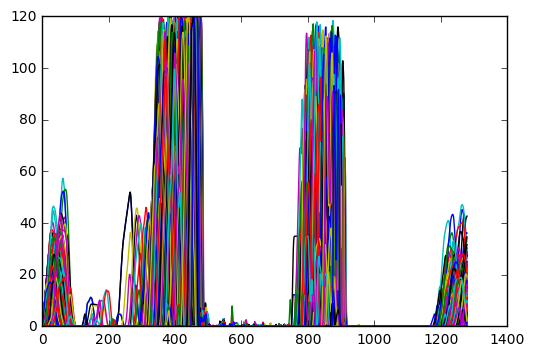

In [222]:
output_video1 = 'project_video_output.mp4'
input_video1 = VideoFileClip("project_video.mp4")
output_clip1 = input_video1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip1.write_videofile(output_video1, audio=False)

In [12]:
white_output = 'project_video_.mp4'
HTML("""
<video width="640" height="320" controls>
  <source src="{0}">
</video>
""".format(output_video1))